In [34]:
!nvidia-smi

Sat Jul  6 13:11:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   72C    P8              18W /  80W |   2426MiB /  6144MiB |     37%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
# import libraries
import seaborn as sns
import pandas as pd 
import numpy as np 
import torch
import random
import os, sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange

from scipy.linalg import inv, cho_factor, cho_solve
import glob
import optuna

torch.manual_seed(1)
from Kalman_module_trial import *
from augment import *
from normalize import Normalization
from model import lstm_encoder, lstm_decoder, lstm_seq2seq, EnsembleModel, xavier_initialize, he_initialize
from utils import *
from dataset import TrajDataset
import pickle as pkl
# from dataset import TrajDataset

#
# from ray import tune
# # from ray.air import Checkpoint, session
# from ray.tune.schedulers import ASHAScheduler


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

/home/anshul/miniconda3/envs/uncertainty_aware/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3060 Laptop GPU'

In [2]:
path = "Dataset/"

# List of flies sequence [hotel, eth, zara01, zara02]:
listoffiles = glob.glob(os.path.join(path,"*.txt"))

# print(listoffiles)
look_back = 8
forward_pred = 12


csv_columns = ["frame_id", "agent_id", "pos_x", "pos_z", "pos_y", "vel_x", "vel_z", "vel_y"]
test_data_name = 'obsmat_eth.txt'
train_data_name = ['obsmat_zara01.txt','obsmat_zara02.txt','obsmat_hotel.txt','obsmat_ucy.txt']
dataframes_train = [pd.read_csv(f,sep=r"\s+", header=None, names=csv_columns) for f in listoffiles if f.endswith(tuple(train_data_name))]
dataframe_test = [pd.read_csv(f,sep=r"\s+", header=None, names=csv_columns) for f in listoffiles if f.endswith(test_data_name)]

'''
creates a pandas dataframe for the five pedestrian datasets. sub_df is the sub dataframe for each unique agent 
within the dataset that is concatenated to form the filtered_dfs.
'''
def create_df(dataframe):

    indices = [1000, 2000, 3000, 4000, 5000]
    if dataframe == dataframe_test:
        indices = [5000]
    filtered_dfs =[]
    idx = 0
    for df in dataframe:
    #     newdf = df.sort_values(by = 'agent_id')
        unique_id = np.unique(df['agent_id'])
        # print(newdf.head(50))


        sub_dfs, filtered_ids = [], []
        for id in unique_id:
            sub_df = df[df['agent_id'] == id].copy()
        #     print("sub_df len : {}".format(len(sub_df)))
            if len(sub_df) < (look_back + forward_pred):
                continue
            filtered_ids.append(id)
            sub_df['agent_id'] = sub_df['agent_id'] + indices[idx]
            sub_df = sub_df.sort_values(by = 'frame_id')
            sub_dfs.append(sub_df)
    #     print("length of filtered_ids:", len(filtered_ids))
        filtered_dfs.append(pd.concat(sub_dfs, ignore_index=True))
        idx += 1

    data = pd.concat(filtered_dfs, axis = 0)
#     print(data)
    return data



In [3]:

# np.set_printoptions(threshold=sys.maxsize)
# np.unique(df['agent_id'])

In [4]:
# Create train and test dataframe:
train_df = create_df(dataframes_train)
test_df = create_df(dataframe_test)
df = pd.concat([train_df, test_df], axis = 0)
agents = np.unique(df['agent_id'])
random.shuffle(agents)

training_fraction = 0.85
num_train_agents = int(training_fraction*len(agents))
train_agents = agents[:num_train_agents]
test_agents = agents[num_train_agents:]


train_agents = train_agents[:300]
test_agents = test_agents[:60]

test_agents  = set(test_agents) - set(test_agents).intersection(set(train_agents))
test_agents = list(test_agents)

# Unique train, test and val agents
val_fraction = 0.15
num_val_agents = int(val_fraction * len(train_agents))
val_agents = train_agents[:num_val_agents]
train_agents = train_agents[num_val_agents:]

# Indices of val, train and test agents
print("common elements if any:", set(train_agents).intersection(set(val_agents)))
print("common elements if any:", set(train_agents).intersection(set(test_agents)))
print("common elements if any:", set(test_agents).intersection(set(val_agents)))
test_agents = test_agents

common elements if any: set()
common elements if any: set()
common elements if any: set()


In [5]:
# # Obtain the unique train and test agents:
# '''
# Splitting agents randomly based on agent id into train and test agents 
# '''
# training_fraction = 0.85
# unique_agent_ids = np.unique(data['agent_id'])


# train_agents = np.random.choice(unique_agent_ids, size= int(training_fraction*len(unique_agent_ids)), replace = False)
# test_agents = set(unique_agent_ids) -set(train_agents)

# train_agents = train_agents
# test_agents  = np.array(list(test_agents))

# print("common elements if any:", set(train_agents).intersection(set(test_agents)))
# print(f"Train_agents :{len(train_agents)} \t Test_agents :{len(test_agents)} \t Total_agents: {len(unique_agent_ids)} ") 

# # Split the data into train and test data:
# train_df = data[data['agent_id'].isin(train_agents)]
# test_df = data[data['agent_id'].isin(test_agents)]

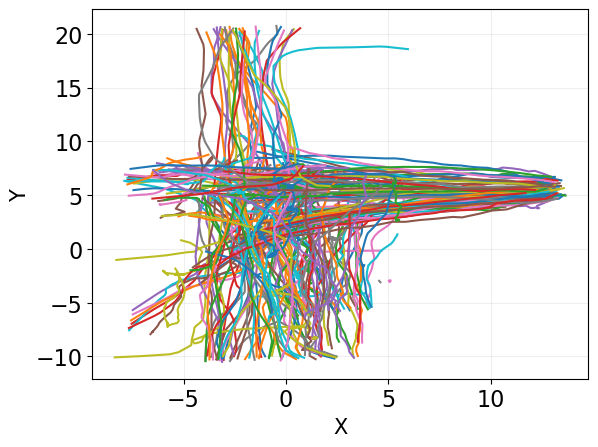

In [6]:
'''
Plotting the trajectories present within train data.
(pos_x, pos_y): (x,y) coordinate of pedestrian about the origin
'''

timesteps_arr = []
index = []
hist_x = []
hist_y = []
thres1 = look_back + forward_pred
agent_ids = [] 

for agent_id in train_agents:
    sub_df = df[df['agent_id'] == agent_id]
    frame, posx, posy = sub_df['frame_id'], sub_df["pos_x"] - 0*sub_df["pos_x"].iloc[0] , sub_df["pos_y"] - 0*sub_df["pos_y"].iloc[0]
    plt.plot(posx, posy, markersize=10, markerfacecolor ='white', label=f"Agent_id:%.0f"%agent_id)
'''
    if (posy.iloc[-1] - posy.iloc[0] >5):
      index.append(agent_id)
      filtered_df = data[data['agent_id'].isin(index)]
      frame, posx, posy = filtered_df['frame_id'], sub_df['pos_x'], sub_df['pos_y']
'''
        

# plt.legend(loc = "upper right")
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.grid("on", alpha=0.2)
plt.locator_params(integer=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Single_Trajectory.pdf', bbox_inches='tight',  dpi = 300)
plt.show()

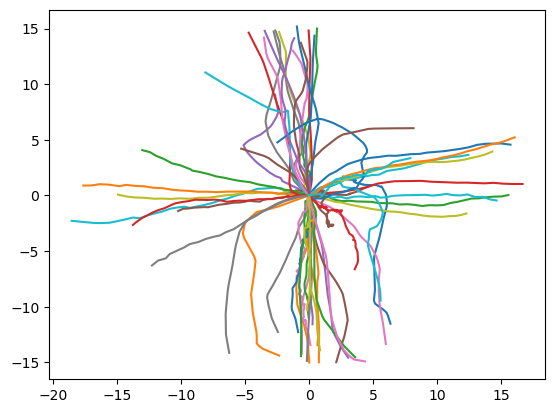

In [7]:
'''
Plotting the trajectories present within test data.
The test data is out of distribution with train data.
'''

for agent_id in test_agents:
    sub_df = df[df['agent_id'] == agent_id]
    frame, posx, posy = sub_df['frame_id'], sub_df["pos_x"] - 1*sub_df["pos_x"].iloc[0] , sub_df["pos_y"] - 1*sub_df["pos_y"].iloc[0]
    plt.plot(posx, posy, markersize=10, markerfacecolor ='white', label=f"Agent_id:%.0f"%agent_id)

In [8]:
'''
This creates train and test data from the data frame. 
data_x: [x,y,u,v] shape: N,look_back(8),features(4)
data_y: [x,y,u,v] shape: N,forward_pred(12),features(12)
'''

def create_dataset(dataframe, agent_id_list, lookback, forward_pred, skip, coord_trnsf ="original"):
    
    '''
    Create_dataset function generates trajectory through a sliding window approach of skip = 1. The 
    shape of train/test dataset: N_traj x  20 (lookback(8) + forwardpred(12))  x 4 (num_fea = [xyuv]).
    
    Parameters:
    - dataframe: DataFrame containing trajectory data.
    - agent_id_list: List of agent IDs to consider for generating the dataset.
    - lookback: Number of past steps to consider.
    - forward_pred: Number of future steps to predict.
    - coord_trnsf: Coordinate transformation mode ('original', 'first_obs', 'last_obs').
    - skip: Step size for the sliding window.
    
    Below, we present list of coordinate transformations:
    1. original: If the trajectories are kept as original without any coordinate transformation.
    2. first_obs: Trajectories are transformed such that the start of each trajectory is origin.
    3. last_obs: Trajectories are transformed such that the last obs point i.e. N_seq = 8 is at origin(0,0) 
    '''
    data_x = []
    data_y = []
    initial_pos = []
    for agent_id in agent_id_list:
        sub_df = dataframe[dataframe["agent_id"]==agent_id]

    # Change the coordinate frame of the Pedestrian Trajectory:
    # sub_df["pos_x"] = sub_df["pos_x"] -sub_df["pos_x"].iloc[0]
    # sub_df["pos_y"] = sub_df["pos_y"] -sub_df["pos_y"].iloc[0]


    # print(sub_df["pos_x"].iloc[0], sub_df["pos_y"].iloc[0])
         
            
        for j in range(0, len(sub_df)-lookback-forward_pred+1, skip):
            if (coord_trnsf == "original"):
                factor = 0
                origin = j
            elif (coord_trnsf == "first_obs"):
                factor = 1
                origin = j
            elif (coord_trnsf == "last_obs"):
                factor = 1
                origin = j+lookback-1
            else:
                raise ValueError("Invalid coordinate transformation mode.")

            df1 = sub_df.iloc[j:j+lookback, [dataframe.columns.get_loc(c) for c in ["pos_x", "pos_y"]]]\
            - factor*sub_df.iloc[origin, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]]
            df2 = sub_df.iloc[j:j+lookback, [dataframe.columns.get_loc(c) for c in ["vel_x","vel_y"]]]
            data_x.append(pd.concat([df1, df2], axis = 1)) # pos_x = 3, pos_y = 5, .... (from the indices of the dataframe)


            df3 = sub_df.iloc[j+lookback:j+lookback+forward_pred, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]]\
            - factor*sub_df.iloc[origin, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]]
            df4 = sub_df.iloc[j+lookback:j+lookback+forward_pred, [dataframe.columns.get_loc(c) for c in ["vel_x","vel_y"]]]
            data_y.append(pd.concat([df3,df4], axis =1))
        
            starting_pos = factor*sub_df.iloc[origin, [dataframe.columns.get_loc(c) for c in ["pos_x","pos_y"]]] # Starting position of pedestrian
            initial_pos.append(starting_pos)

    return np.array(data_x), np.array(data_y), np.array(initial_pos)

In [9]:
# Create the train and test dataset:
skip = 1 # step size for sliding window
X_train, y_train, train_init_pos  = create_dataset(df, train_agents, look_back, forward_pred, skip, coord_trnsf="original")
X_val, y_val, val_init_pos = create_dataset(df, val_agents, look_back, forward_pred, skip, coord_trnsf="original")
X_test,y_test, test_init_pos = create_dataset(df, test_agents, look_back, forward_pred, skip, coord_trnsf="original")


# Concat to obtain complete train and test traj: 
train_traj = np.concatenate((X_train, y_train), axis = 1)
val_traj = np.concatenate((X_val,y_val), axis = 1)
test_traj = np.concatenate((X_test, y_test), axis = 1)

In [10]:
X_train.shape

(6507, 8, 4)

ID: 4142


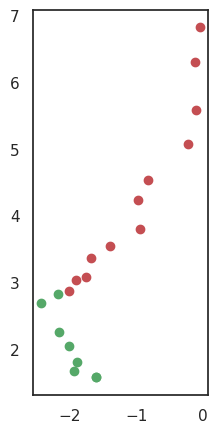

In [44]:
fig, ax = plt.subplots()
for id in np.random.choice(train_traj.shape[0], 1, replace=False):
    plt.scatter(train_traj[id,:look_back,0],train_traj[id,:look_back,1], color='g')
    plt.scatter(train_traj[id,look_back:,0],train_traj[id,look_back:,1], color='r')
    print("ID:",id)
ax.set_aspect('equal', adjustable='box')
    
plt.show()

In [45]:
# Data Augmentation using random rotation and swap
augmenter = Augmentation()
swap_fraction = 0.0 # Randomly swap 40% trajectories
num_traj_swap = int(swap_fraction*len(train_traj))
swap_traj = augmenter.swap_xyuv(train_traj[:num_traj_swap,:,:])
rotated_traj = augmenter.random_rotate(train_traj[num_traj_swap:,:,:])
augmented_traj = np.concatenate((swap_traj,rotated_traj),axis = 0)

In [46]:
train_agents[:num_traj_swap].shape

(0,)

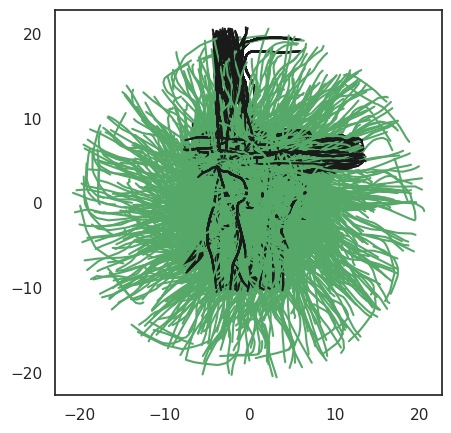

In [47]:
fig,ax = plt.subplots()
for id in range(train_traj.shape[0]):
    ax.plot(train_traj[id,:,0],train_traj[id,:,1], color='k')
    ax.plot(augmented_traj[id,:,0],augmented_traj[id,:,1], color='g')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [48]:
train_traj = np.concatenate((augmented_traj,train_traj), axis =0)
# train_traj = rotated_train_traj

In [49]:
'''
Function get_N_trajectories is called to obtain num_traj = 7 different sampled trajectories 
from the distribution obtained using KF. 
batch_traj_test: N_test, 7, 20, 4
batch_traj_mu:  N_test, 7, 20, 4
batch_traj_cov:  N_test, 7, 20, 4 [contains only diagonal elements of the variables; no off-diagonal]
'''

num_traj = 3
f = 0.00 # 5% prior sensing uncertainty to KF. DO NOT increase uncertainty beyond 10%, it will mess up training 

def generate_sampled_trajectories(traj, num_traj,f):
    f_traj, f_mu, f_cov =[], [], []
    # for id in np.random.choice(train_traj.shape[0],5):  
    for id in range(traj.shape[0]):
        noise = np.random.normal(0, 0.1*f,1)
        f_new = f + noise
        X_seq = traj[id,:,:]
        trajectories, mus, covs = get_N_trajectories(X_seq, num_traj, f_new)
        f_traj.append(trajectories)
        f_mu.append(mus)
        f_cov.append(covs)

    f_traj, f_mu, f_cov = np.array(f_traj), np.array(f_mu), np.array(f_cov)
    batch_traj = np.squeeze(f_traj)
    batch_cov = np.squeeze(f_cov)
    batch_mu = np.squeeze(f_mu)
    
    return batch_traj, batch_mu, batch_cov

In [51]:
N_train_traj, train_mu, train_cov = generate_sampled_trajectories(train_traj, num_traj, f)
N_val_traj, val_mu, val_cov = generate_sampled_trajectories(val_traj, num_traj, f)
N_test_traj, test_mu, test_cov = generate_sampled_trajectories(test_traj, num_traj, f)

In [ ]:
print(N_train_traj.shape)
print(N_val_traj.shape)
print(N_test_traj.shape)

(12970, 3, 20, 4)
(852, 3, 20, 4)
(1166, 3, 20, 4)


In [ ]:
print(train_mu[0,1,:,:2])

[[-4.52233746  4.65385989]
 [-4.37810885  4.31491432]
 [-4.27723027  4.05261793]
 [-4.21577752  3.87721236]
 [-4.16534926  3.72954196]
 [-4.11290177  3.58488927]
 [-4.05125658  3.43143689]
 [-4.00134532  3.31576604]
 [-3.97560525  3.2640579 ]
 [-3.97490481  3.27423372]
 [-4.06833465  3.29749062]
 [-4.18825942  3.29218061]
 [-4.18280143  3.2992956 ]
 [-4.16626339  3.24926819]
 [-4.06531927  3.17020157]
 [-3.9839958   3.06451549]
 [-3.91910947  2.84697397]
 [-3.75832335  2.55006211]
 [-3.62256183  2.18804159]
 [-3.49705391  1.84471941]]


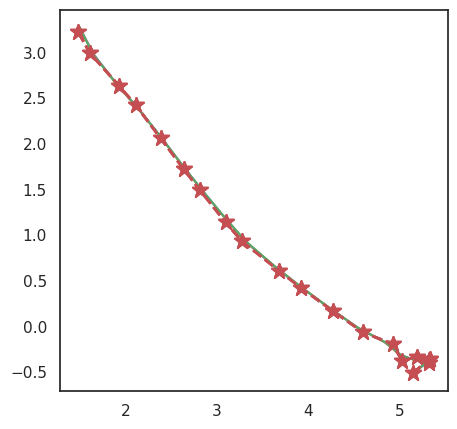

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.set_theme(style='white')
# .detach().cpu().numpy()
id = 10
for i in range(N_train_traj.shape[1]):
    plt.plot(N_train_traj[id,i, :, 0], N_train_traj[id,i, :, 1])
    plt.plot(train_traj[id,:,0],train_traj[id,:,1], lw=2., ms=12., marker='*', color="r", linestyle="dashed")
#     plt.ylim([6,10])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

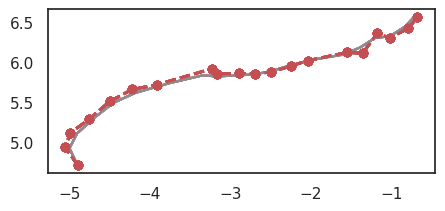

In [ ]:
# Plot showing test trajectories for a particular ID
sns.set(rc={'figure.figsize':(5,5)})
sns.set_theme(style='white')
# .detach().cpu().numpy()
id = 10
for traj in (np.random.choice(N_test_traj.shape[1],8)):
    plt.plot(N_test_traj[id,traj, :, 0], N_test_traj[id,traj, :, 1])
    plt.plot(test_traj[id,:,0],test_traj[id,:,1], lw=2., ms=6., marker='o', color="r", linestyle="dashed")
#     plt.ylim([6,10])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

<Figure size 1000x300 with 0 Axes>

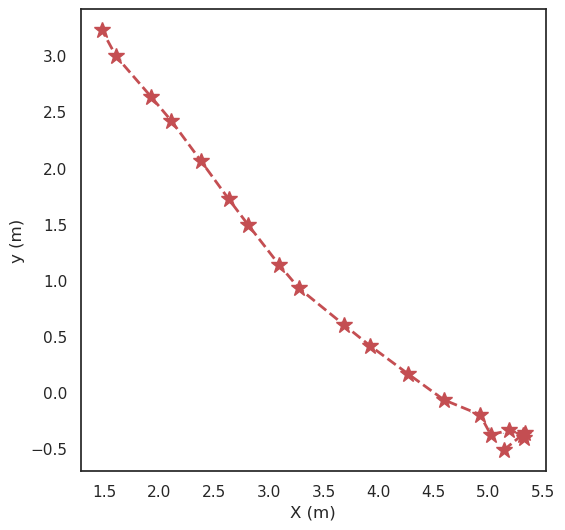

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib as mpl

# plt.style.use('seaborn-white')
plt.figure(figsize=(10,3))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex=False, sharey=True)

for point in range(20):
#     ax.scatter(batch_traj[id,:,point,0], batch_traj[id,:,point,1], color="b")
    ax.plot(train_traj[id,point,0], train_traj[id,point,1], lw= 4 -0.15*point, ms=12., marker='*', color="r", linestyle="dashed")

    cov = np.cov(N_train_traj[id,:,point,0],N_train_traj[id,:,point,1] ) 
    lambda_, v_ = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
#         print(lambda_tot)

    for j in range(1,2):
        ell1 = Ellipse(xy = (N_train_traj[id,:,point,0].mean(), N_train_traj[id,:,point,1].mean()),
                 width = (lambda_[0] *1) * j* 2 ,
                 height = (lambda_[1] *1) *j* 2,
                    angle = np.rad2deg(np.arccos((v_[0,0]))),
                     color = 'black',  lw = 0.5) 
        ell1.set_facecolor('green')
        ell1.set_alpha(0.25)
        ax.add_artist(ell1)
# ax.axis('equal')
ax.plot(train_traj[id,:,0],train_traj[id,:,1], lw=2, ms=6., marker='*', color="r", linestyle="dashed")
plt.xlabel('X (m)')
plt.ylabel('y (m)')
plt.show()

In [ ]:
# Loading the data on the device
num_fea = 2
batch_traj_temp = torch.tensor(N_train_traj[:,:,:,:num_fea]).float().to(device) # shape: batch, num_traj, seq, features
# X_train, y_train = torch.tensor(X_train[:,:,:num_fea]).float().to(device), torch.tensor(y_train[:,:,:num_fea]).float().to(device)
X_train_KF, y_train_KF = torch.split(batch_traj_temp, [8,12], dim = 2) # shape: batch, num_traj, seq, features

batch_traj_test_temp = torch.tensor(N_test_traj[:,:,:,:num_fea]).float().to(device)
# X_test, y_test = torch.tensor(X_test[:,:,:num_fea]).float().to(device), torch.tensor(y_test[:,:,:num_fea]).float().to(device)
X_test_KF, y_test_KF = torch.split(batch_traj_test_temp, [8,12], dim = 2) # shape: batch, num_traj, seq, features


def normalize_data(data):
    reshaped_data = data.reshape(-1, data.shape[-1])
    
    mean = torch.mean(reshaped_data, dim = 0)
    std = torch.std(reshaped_data, dim = 0)
    
    normalized_data = (data - mean)/std
    return normalized_data, mean, std

def denormalize_data(data, mean, std):
    denormalized_data = (data * std) + mean
    return denormalized_data

def generate_dataloader(mu, cov, num_fea, normalize = True):
    gaussian_traj =  np.concatenate([mu[:,:,:,:num_fea], cov[:,:,:,:num_fea]], axis =3) # shape: batch, num_traj, seq, features *2
    gaussian_traj = torch.tensor(gaussian_traj).float().to(device)
    if normalize:
        gaussian_traj, mean, std = normalize_data(gaussian_traj)
        input_traj, output_traj = torch.split(gaussian_traj, [8,12], dim = 2)
        return gaussian_traj, input_traj, output_traj, mean, std
    else:
        mean, std  = None, None
        input_traj, output_traj = torch.split(gaussian_traj, [8,12], dim = 2)
        return gaussian_traj, input_traj, output_traj
    
    
gaussian_train_traj, train_input, train_output = generate_dataloader(train_mu, train_cov, num_fea, normalize = False)
gaussian_val_traj, val_input, val_output = generate_dataloader(val_mu, val_cov, num_fea, normalize = False)
gaussian_test_traj, test_input, test_output = generate_dataloader(test_mu, test_cov, num_fea, normalize = False)

# Look for other augmentation at the end of the simulation after ADE/FDE computation

In [ ]:
# with open('Optuna_hyperparameter.pkl','rb') as f:
#     study = pkl.load(f)
    
# study.trials

In [ ]:
# Create the tensor dataset
from torch.utils import tensorboard
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary

# Define the full path to your log directory
log_dir = r"/home/anshul/OneDrive/Pred_unc_aware_planning/Deep_Ensemble/runs/Attention"

# Ensure the directory exists
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)


idx = list(range(num_traj))
random.shuffle(idx)


batch_size = 128
hidden_size = 256
dropout = 0.40
beta = 0.1
teacher_forcing_ratio = 0.6952979064310219
learning_rate = 0.0031
num_layers = 2
num_models = 1
dynamic_TF = False
optimizer_name = 'RMSProp'
num_fea = train_input.shape[3]
preds, sigmas = [],[]
losses = []
train_MSE, test_MSE = [], []
min_val = -1
max_val = 1

def objective(trial):

    # Log trial information
    print(f"Starting trial {trial.number} with parameters: {trial.params}")


    # Define search space:
    '''
    optuna results:
    Best trial:
    Value: 0.03539485640690795
    params: 
    learning_rate: 0.001597064489725669
    teacher_forcing_ratio: 0.18259437319603056
    batch_size: 32
    optimizer_name: RMSProp
    hidden_state: 256


    {'learning_rate': 0.00803494629958372, 
    'teacher_forcing_ratio': 0.8818260080309833,
    'batch_size': 32, 
    'optimizer_name': 'Adam', 
    'hidden_size': 64, 
    'init_weight': 'xavier_initialize',
    'dynamic_tf': 'True',
    'dropout': 0.30287832302041306}

    '''
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2) 
    beta = trial.suggest_categorical('beta', [0.1, 0.2, 0.3, 0.4, 0.5])
    teacher_forcing_ratio = trial.suggest_float('teacher_forcing_ratio', 0.0, 1.0)
    batch_size = trial.suggest_categorical('batch_size',[32, 64,128,256])
    optimizer_name = trial.suggest_categorical('optimizer_name',['Adam','SGD','RMSProp'])
    hidden_size = trial.suggest_categorical('hidden_size',[64, 128, 256])
    # init_weight = trial.suggest_categorical('init_weight',['xavier_initialize','he_initialize'])
    dynamic_TF = trial.suggest_categorical('dynamic_tf',['True','False'])
    dropout = trial.suggest_float('dropout', 0, 0.5)

    # hidden_size = np.random.choice([64,128,256])
    deep_ensemble = EnsembleModel(input_size = num_fea, hidden_size = hidden_size, output_size = num_fea + 2, num_layers = num_layers, 
                                    dropout = dropout,  use_attention= True, device = device, num_models = num_models, init_weight = None)

    ensemble_val_loss = []
    for i, model  in enumerate(deep_ensemble.models):

    #     print(i)
    #     train_data = TrajDataset(train_input[:,i,:,:], train_output[:,i,:,:], min_val = min_val, max_val = max_val)
    #     val_data =  TrajDataset(val_input[:,i,:,:], val_output[:,i,:,:], min_val = min_val, max_val = max_val)
    #     test_data = TrajDataset(test_input[:,i,:,:], test_output[:,i,:,:], min_val = min_val, max_val = max_val)

        train_data = TensorDataset(train_input[:,i,:,:], train_output[:,i,:,:])
        val_data =  TensorDataset(val_input[:,i,:,:], val_output[:,i,:,:])
        test_data = TensorDataset(test_input[:,i,:,:], test_output[:,i,:,:])

        # Train, validataion and Test DataLoader
        train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = False)
        val_loader =   DataLoader(val_data, batch_size = batch_size, shuffle = False)
        test_loader =  DataLoader(test_data, batch_size = batch_size, shuffle = False)
        
    #     train_features, train_labels = next(iter(train_loader))
    #     print('Train Features :',train_features)
    #     print('Train labels :',train_labels)

    # Load the model
    #     model = lstm_seq2seq(input_size = num_fea ,hidden_size = 128, device = device)
    #     print(model)

    #     break

        loss, val_loss = model.train_model(device,
                                train_loader, 
                                val_loader,
                                n_epochs = 100, 
                                target_len = forward_pred, 
                                beta = beta,
                                training_prediction ='teacher_forcing', 
                                teacher_forcing_ratio = teacher_forcing_ratio, 
                                learning_rate = learning_rate,  
                                dynamic_tf = dynamic_TF,
                                optimizer_name = optimizer_name,
                                writer = writer
                                )
        
        # for n_iter in range(loss.shape):
        #     writer.add_scalar('Training Loss', loss[n_iter], n_iter)
        #     writer.add_scalar('validation Loss', val_loss[n_iter], n_iter)
            
        print('Model No.{} trained.'.format(i+1))
        valid_val_losses = [loss for loss in val_loss if not np.isnan(loss)]
        if valid_val_losses:
            last_valid_val_loss = valid_val_losses[-1]
        else:
            last_valid_val_loss = np.inf
        print(last_valid_val_loss)
        ensemble_val_loss.append(last_valid_val_loss)

        # # summarize history for loss
        # #     plt.plot(history.history['loss'])
        # #     plt.plot(history.history['val_loss'])
        # #     plt.title('model loss')
        # #     plt.ylabel('loss')
        # #     plt.xlabel('epoch')
        # #     plt.legend(['train', 'test'], loc='upper left')
        # #     plt.show()
        plt.figure(figsize=(3,2), dpi=150)
        plt.plot(loss, lw=2.,color = 'r', label = 'Train Loss')
        plt.plot(val_loss,lw=2.,color = 'b', label = 'val Loss')
        # plt.yscale("log")
        plt.grid("on", alpha=0.2)
        plt.ylabel("NLL Loss", fontsize=12)
        plt.xlabel("Epochs", fontsize=12)
        plt.legend()
        plt.show()

        
        min_logvar, max_logvar = -4, 4

        y_train_pred = model.predict(val_input[:,i,:,:], forward_pred, device)
        # y_train_pred = model.predict(X_train, target_len=forward_pred)
    #     y_train_pred_mean_mu, y_train_pred_mean_sigma, y_train_pred_logvar = y_train_pred[:,:,:int(num_fea/2)], torch.abs(y_train_pred[:,:,int(num_fea/2):num_fea]),  y_train_pred[:,:,num_fea:]#target_len, b, 8
        y_train_pred_mu,   y_train_state_logvar, y_train_pred_logvar = y_train_pred[:,:,:int(num_fea/2)], (y_train_pred[:,:,int(num_fea/2):num_fea]), (y_train_pred[:,:,num_fea:])#target_len, b, 8
        y_train_state_var = torch.exp(y_train_state_logvar)
        y_train_pred_logvar = torch.clamp(y_train_pred_logvar, min=min_logvar, max=max_logvar)
        y_train_pred_mean = torch.cat((y_train_pred_mu, y_train_state_var),2)
    #     y_train_pred_mean = denormalize_data(y_train_pred_mean, train_mean,  train_std)
        
        # Denormalize Data:
        mse_train = ((y_train_pred_mean - val_output[:,i,:,:num_fea])**2).mean()
        print(f"Train MSE: {mse_train}")

        y_test_pred = model.predict(test_input[:,i,:,:], target_len=forward_pred, device = device)
        # y_test_pred = model.predict(X_test, target_len=forward_pred)
    #     y_test_pred_mean_mu, y_test_pred_mean_sigma, y_test_pred_logvar = y_test_pred[:,:,:int(num_fea/2)],  torch.abs(y_test_pred[:,:,int(num_fea/2):num_fea]), y_test_pred[:,:,num_fea:]#target_len, b, 8
        y_test_pred_mu , y_test_state_logvar, y_test_pred_logvar = y_test_pred[:,:,:int(num_fea/2)], (y_test_pred[:,:,int(num_fea/2):num_fea]), (y_test_pred[:,:,num_fea:])#target_len, b, 8
        y_test_state_var = torch.exp(y_test_state_logvar)
        y_test_pred_logvar = torch.clamp(y_test_pred_logvar, min=min_logvar, max=max_logvar)
        y_test_pred_mean = torch.cat((y_test_pred_mu, y_test_state_var),2)
    #     y_test_pred_mean = denormalize_data(y_test_pred_mean, train_mean,  train_std)
        
        # Denormalize Data:
        mse_test = ((y_test_pred_mean - test_output[:,i,:,:num_fea])**2).mean()
        print(f"Test MSE: {mse_test}")
        
    #     train_MSE.append(mse_train)
    #     test_MSE.append(mse_test)
    #     losses.append(loss)
    #     preds.append(y_test_pred_mean)
    #     sigmas.append(y_test_pred_logvar)

    # Close the writer
    writer.close() 

    return min(ensemble_val_loss)


[I 2024-07-06 11:45:57,778] A new study created in memory with name: no-name-0d34fe5f-bc6a-40af-afa8-cab151ba96a2


Starting trial 0 with parameters: {}


 56%|█████▌    | 56/100 [01:09<00:54,  1.24s/it, loss=-0.167, val_loss=-0.052]

Early stopping triggered
Model No.1 trained.
-0.05141899106092751


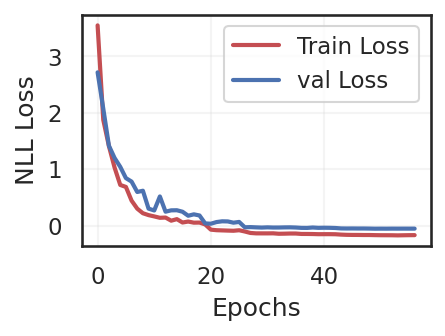

Train MSE: 0.18004971742630005
Test MSE: 0.16508722305297852


 65%|██████▌   | 65/100 [01:20<00:43,  1.24s/it, loss=-0.197, val_loss=-0.065]

Early stopping triggered
Model No.2 trained.
-0.06483977055177093


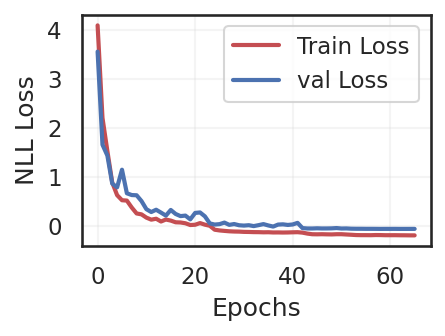

Train MSE: 0.1682014912366867
Test MSE: 0.1520463228225708


 30%|███       | 30/100 [00:39<01:31,  1.31s/it, loss=-0.117, val_loss=0.069]

Early stopping triggered
Model No.3 trained.
0.024329427629709244


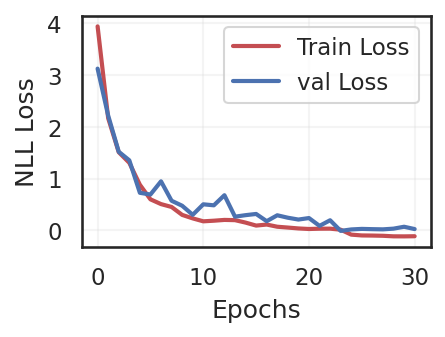

[I 2024-07-06 11:49:07,730] Trial 0 finished with value: -0.06483977055177093 and parameters: {'learning_rate': 0.007050549528720043, 'beta': 0.3, 'teacher_forcing_ratio': 0.4004398572386966, 'batch_size': 256, 'optimizer_name': 'RMSProp', 'hidden_size': 128, 'dynamic_tf': 'False', 'dropout': 0.3721133061907674}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.2173965573310852
Test MSE: 0.20787157118320465
Starting trial 1 with parameters: {}


 41%|████      | 41/100 [02:27<03:32,  3.59s/it, loss=-0.045, val_loss=0.042]

Early stopping triggered
Model No.1 trained.
0.04219779501350045


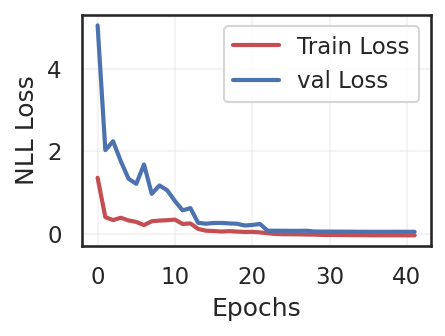

Train MSE: 0.19983811676502228
Test MSE: 0.17365583777427673


 32%|███▏      | 32/100 [01:55<04:05,  3.61s/it, loss=-0.035, val_loss=0.043]

Early stopping triggered
Model No.2 trained.
0.04289984923821909


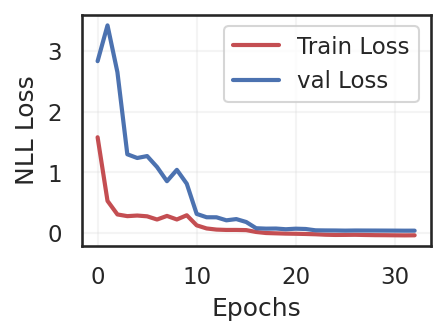

Train MSE: 0.19767051935195923
Test MSE: 0.17871879041194916


 40%|████      | 40/100 [02:24<03:36,  3.61s/it, loss=-0.040, val_loss=0.037]

Early stopping triggered
Model No.3 trained.
0.03717126352367578


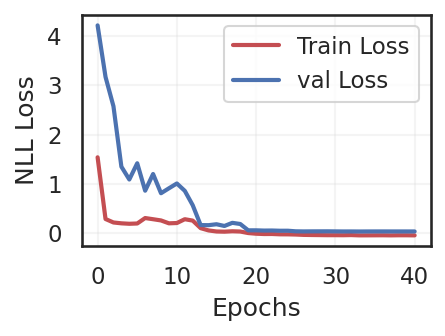

[I 2024-07-06 11:55:55,306] Trial 1 finished with value: 0.03717126352367578 and parameters: {'learning_rate': 0.005340559091819829, 'beta': 0.4, 'teacher_forcing_ratio': 0.9214032531613988, 'batch_size': 32, 'optimizer_name': 'Adam', 'hidden_size': 64, 'dynamic_tf': 'True', 'dropout': 0.3617546373636606}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.19506019353866577
Test MSE: 0.17184926569461823
Starting trial 2 with parameters: {}


 63%|██████▎   | 63/100 [01:56<01:08,  1.84s/it, loss=-0.084, val_loss=0.008]

Early stopping triggered
Model No.1 trained.
0.009075920613083457


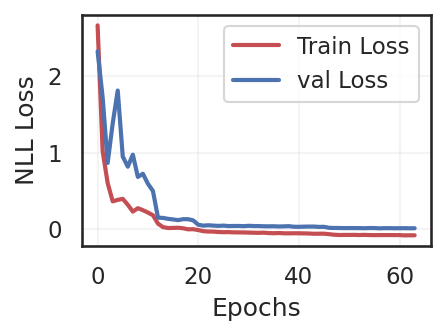

Train MSE: 0.18792757391929626
Test MSE: 0.16956226527690887


 60%|██████    | 60/100 [01:52<01:15,  1.88s/it, loss=-0.097, val_loss=0.007]

Early stopping triggered
Model No.2 trained.
0.006059445257830832


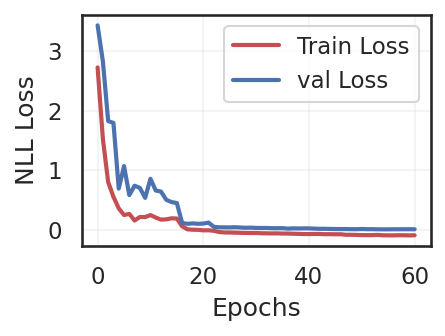

Train MSE: 0.185563325881958
Test MSE: 0.1644296795129776


 56%|█████▌    | 56/100 [01:44<01:21,  1.86s/it, loss=-0.086, val_loss=0.007]

Early stopping triggered
Model No.3 trained.
0.005440849444961974


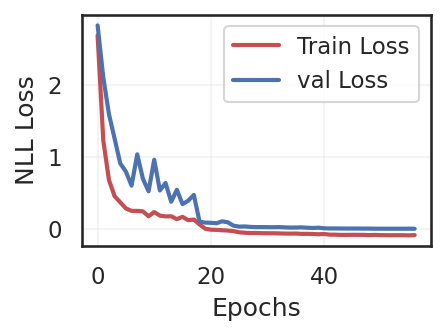

[I 2024-07-06 12:01:28,176] Trial 2 finished with value: 0.005440849444961974 and parameters: {'learning_rate': 0.006522574065761504, 'beta': 0.4, 'teacher_forcing_ratio': 0.47474887548804834, 'batch_size': 64, 'optimizer_name': 'RMSProp', 'hidden_size': 64, 'dynamic_tf': 'False', 'dropout': 0.16580895657722683}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.18546494841575623
Test MSE: 0.16697344183921814
Starting trial 3 with parameters: {}


 39%|███▉      | 39/100 [01:31<02:23,  2.35s/it, loss=-0.146, val_loss=-0.014]

Early stopping triggered
Model No.1 trained.
-0.013670552621728607


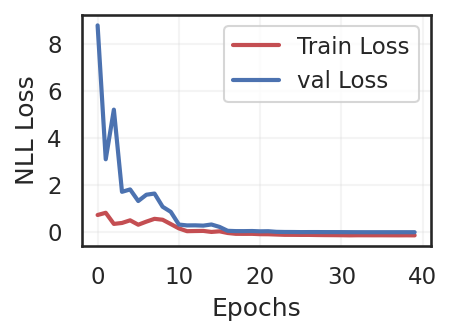

Train MSE: 0.22658540308475494
Test MSE: 0.2326948344707489


 44%|████▍     | 44/100 [01:43<02:11,  2.35s/it, loss=-0.159, val_loss=-0.021]

Early stopping triggered
Model No.2 trained.
-0.020551063253411224


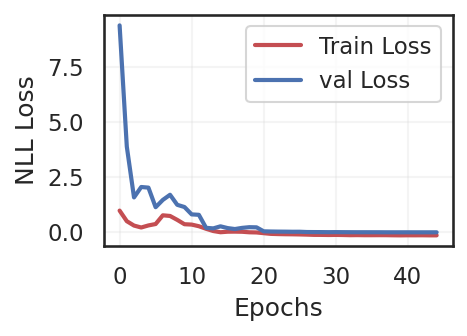

Train MSE: 0.222873717546463
Test MSE: 0.21111425757408142


 44%|████▍     | 44/100 [01:43<02:11,  2.35s/it, loss=-0.147, val_loss=0.006]

Early stopping triggered
Model No.3 trained.
0.006569213167365108


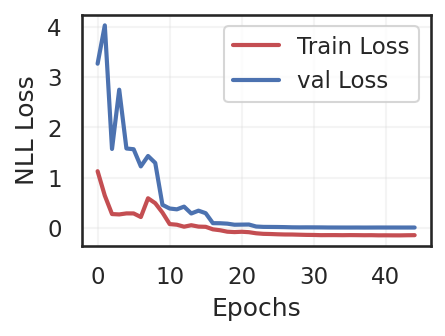

[I 2024-07-06 12:06:27,372] Trial 3 finished with value: -0.020551063253411224 and parameters: {'learning_rate': 0.009713612867001014, 'beta': 0.2, 'teacher_forcing_ratio': 0.9927776473843469, 'batch_size': 64, 'optimizer_name': 'RMSProp', 'hidden_size': 128, 'dynamic_tf': 'True', 'dropout': 0.49119648142415184}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.26657113432884216
Test MSE: 0.27474236488342285
Starting trial 4 with parameters: {}


 63%|██████▎   | 63/100 [01:15<00:44,  1.20s/it, loss=-0.169, val_loss=-0.046]

Early stopping triggered
Model No.1 trained.
-0.046003213385120034


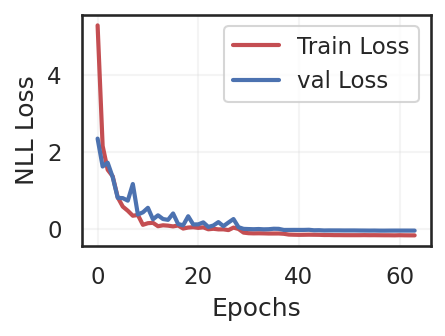

Train MSE: 0.18057873845100403
Test MSE: 0.16160330176353455


 35%|███▌      | 35/100 [00:43<01:20,  1.24s/it, loss=-0.145, val_loss=-0.026]

Early stopping triggered
Model No.2 trained.
-0.03356148675084114


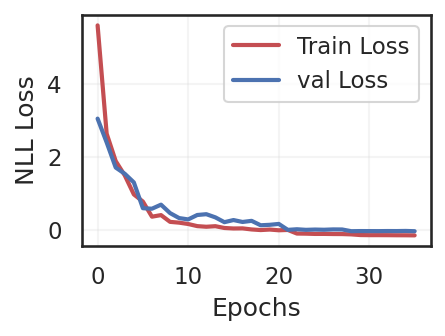

Train MSE: 0.18610531091690063
Test MSE: 0.17119614779949188


 25%|██▌       | 25/100 [00:32<01:37,  1.29s/it, loss=-0.003, val_loss=0.221]

Early stopping triggered
Model No.3 trained.
0.19878932647407055


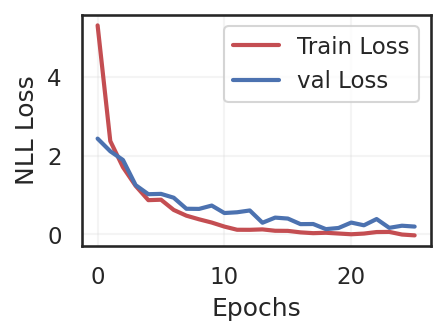

[I 2024-07-06 12:08:59,344] Trial 4 finished with value: -0.046003213385120034 and parameters: {'learning_rate': 0.0009267700936744585, 'beta': 0.3, 'teacher_forcing_ratio': 0.4337385519338218, 'batch_size': 256, 'optimizer_name': 'RMSProp', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.32465000382328807}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.33746078610420227
Test MSE: 0.3099159896373749
Starting trial 5 with parameters: {}


 26%|██▌       | 26/100 [00:49<02:21,  1.91s/it, loss=-0.007, val_loss=0.094]

Early stopping triggered
Model No.1 trained.
0.09173142723739147


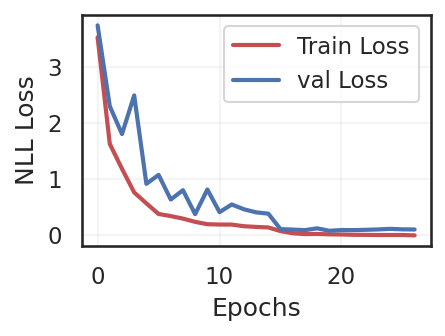

Train MSE: 0.20456606149673462
Test MSE: 0.17661075294017792


 33%|███▎      | 33/100 [01:02<02:07,  1.90s/it, loss=-0.019, val_loss=0.059]

Early stopping triggered
Model No.2 trained.
0.05765122314915061


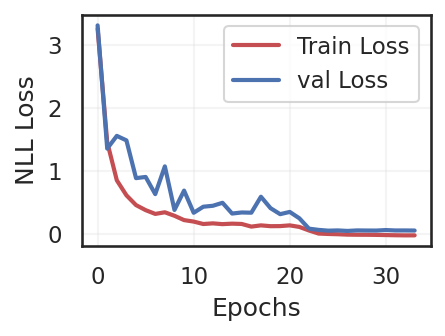

Train MSE: 0.1965455263853073
Test MSE: 0.16766604781150818


 49%|████▉     | 49/100 [01:32<01:36,  1.88s/it, loss=-0.051, val_loss=0.016]

Early stopping triggered
Model No.3 trained.
0.01567078275339944


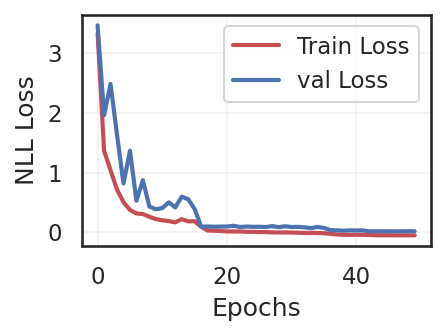

[I 2024-07-06 12:12:24,374] Trial 5 finished with value: 0.01567078275339944 and parameters: {'learning_rate': 0.005245391402154873, 'beta': 0.5, 'teacher_forcing_ratio': 0.17610293825759316, 'batch_size': 64, 'optimizer_name': 'SGD', 'hidden_size': 64, 'dynamic_tf': 'True', 'dropout': 0.1798599389067116}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.17163586616516113
Test MSE: 0.15940190851688385
Starting trial 6 with parameters: {}


 46%|████▌     | 46/100 [00:51<01:00,  1.12s/it, loss=-0.037, val_loss=0.035]

Early stopping triggered
Model No.1 trained.
0.034199620597064495


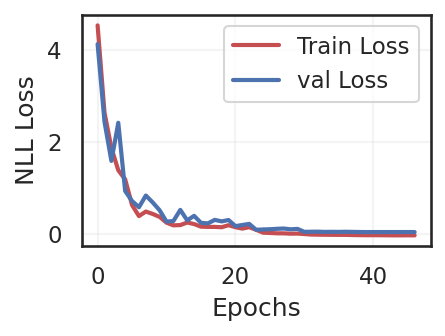

Train MSE: 0.1825743317604065
Test MSE: 0.16061915457248688


 49%|████▉     | 49/100 [01:00<01:02,  1.23s/it, loss=-0.010, val_loss=0.070]

Early stopping triggered
Model No.2 trained.
0.06979444110766053


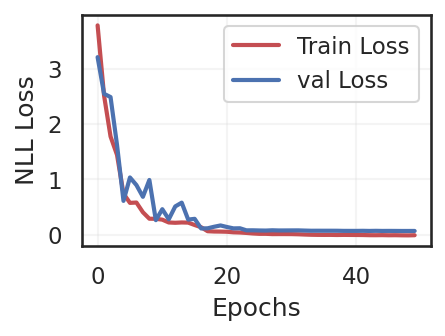

Train MSE: 0.21133475005626678
Test MSE: 0.1881970763206482


 64%|██████▍   | 64/100 [01:21<00:45,  1.27s/it, loss=-0.052, val_loss=0.035]

Early stopping triggered
Model No.3 trained.
0.0353050297126174


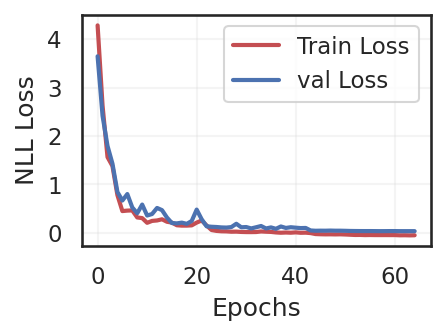

[I 2024-07-06 12:15:37,500] Trial 6 finished with value: 0.034199620597064495 and parameters: {'learning_rate': 0.007338508490407515, 'beta': 0.5, 'teacher_forcing_ratio': 0.4544695537580902, 'batch_size': 256, 'optimizer_name': 'SGD', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.4953851866566362}. Best is trial 0 with value: -0.06483977055177093.


Train MSE: 0.18672296404838562
Test MSE: 0.16806867718696594
Starting trial 7 with parameters: {}


 58%|█████▊    | 58/100 [02:11<01:35,  2.27s/it, loss=-0.461, val_loss=-0.222]

Early stopping triggered
Model No.1 trained.
-0.2232018748639218


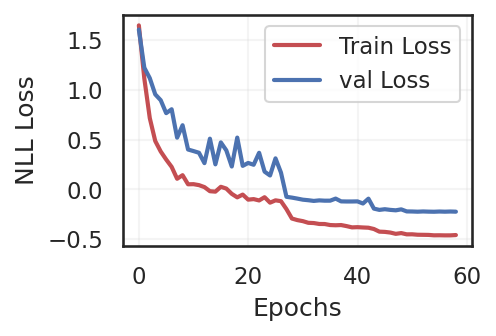

Train MSE: 0.17573736608028412
Test MSE: 0.16458295285701752


 41%|████      | 41/100 [01:33<02:14,  2.27s/it, loss=-0.368, val_loss=-0.121]

Early stopping triggered
Model No.2 trained.
-0.09253256887729679


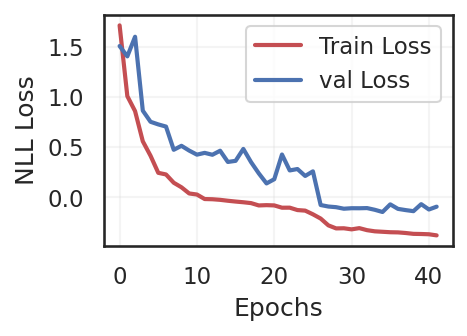

Train MSE: 0.20414681732654572
Test MSE: 0.18242350220680237


 71%|███████   | 71/100 [02:38<01:04,  2.23s/it, loss=-0.467, val_loss=-0.261]

Early stopping triggered
Model No.3 trained.
-0.2606735807244799


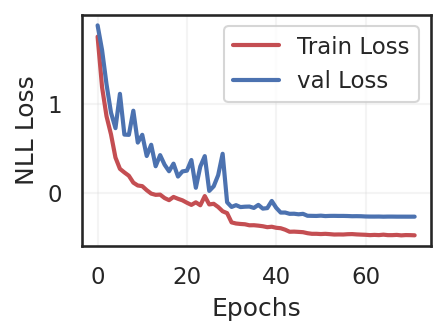

[I 2024-07-06 12:22:00,901] Trial 7 finished with value: -0.2606735807244799 and parameters: {'learning_rate': 0.001283678737274741, 'beta': 0.1, 'teacher_forcing_ratio': 0.3657417247351451, 'batch_size': 64, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.4370672167850658}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.16624490916728973
Test MSE: 0.15588787198066711
Starting trial 8 with parameters: {}


 31%|███       | 31/100 [02:05<04:40,  4.06s/it, loss=-0.022, val_loss=0.051]

Early stopping triggered
Model No.1 trained.
0.049972918143288955


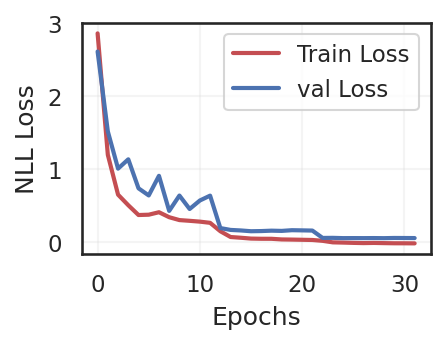

Train MSE: 0.19222335517406464
Test MSE: 0.18074969947338104


 24%|██▍       | 24/100 [01:37<05:09,  4.07s/it, loss=0.121, val_loss=0.392]

Early stopping triggered
Model No.2 trained.
0.4179684722589122


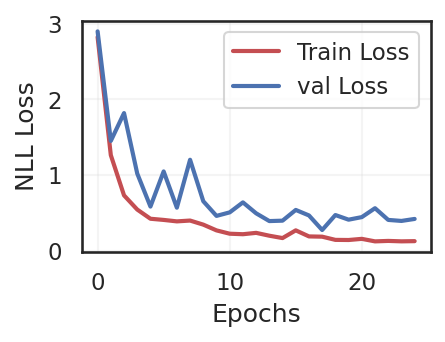

Train MSE: 0.4685647487640381
Test MSE: 0.370806485414505


 22%|██▏       | 22/100 [01:29<05:17,  4.07s/it, loss=0.126, val_loss=0.329]

Early stopping triggered
Model No.3 trained.
0.41702038660231566


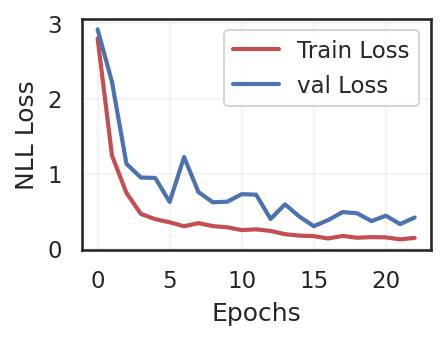

[I 2024-07-06 12:27:14,353] Trial 8 finished with value: 0.049972918143288955 and parameters: {'learning_rate': 0.003480216222140441, 'beta': 0.5, 'teacher_forcing_ratio': 0.002829181847068818, 'batch_size': 32, 'optimizer_name': 'RMSProp', 'hidden_size': 128, 'dynamic_tf': 'False', 'dropout': 0.3924066330392095}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.49022454023361206
Test MSE: 0.46734514832496643
Starting trial 9 with parameters: {}


 64%|██████▍   | 64/100 [02:31<01:24,  2.36s/it, loss=-0.077, val_loss=0.043]

Early stopping triggered
Model No.1 trained.
0.04196232354401478


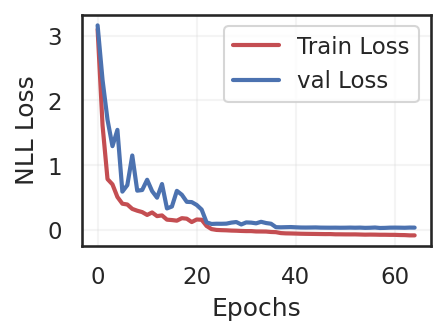

Train MSE: 0.18450869619846344
Test MSE: 0.1709340363740921


 22%|██▏       | 22/100 [00:53<03:09,  2.43s/it, loss=0.155, val_loss=0.452]

Early stopping triggered
Model No.2 trained.
0.5829107175980296


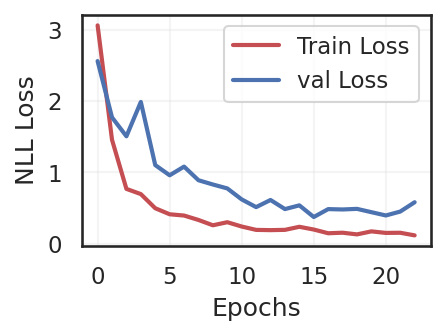

Train MSE: 0.6474475860595703
Test MSE: 0.5853449106216431


 31%|███       | 31/100 [01:14<02:46,  2.41s/it, loss=0.071, val_loss=0.482]

Early stopping triggered
Model No.3 trained.
0.37498155129807337


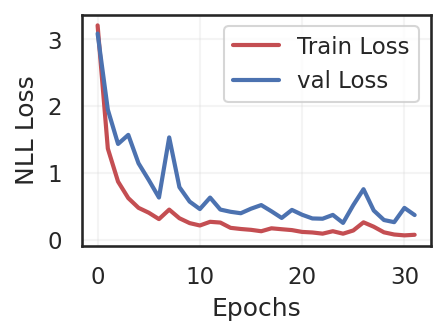

[I 2024-07-06 12:31:54,097] Trial 9 finished with value: 0.04196232354401478 and parameters: {'learning_rate': 0.006120925959612951, 'beta': 0.5, 'teacher_forcing_ratio': 0.017979404033241275, 'batch_size': 64, 'optimizer_name': 'RMSProp', 'hidden_size': 128, 'dynamic_tf': 'True', 'dropout': 0.03713108919175501}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.4097782373428345
Test MSE: 0.3785572648048401
Starting trial 10 with parameters: {}


 81%|████████  | 81/100 [02:02<00:28,  1.51s/it, loss=-0.406, val_loss=-0.191]

Early stopping triggered
Model No.1 trained.
-0.19137480961424963


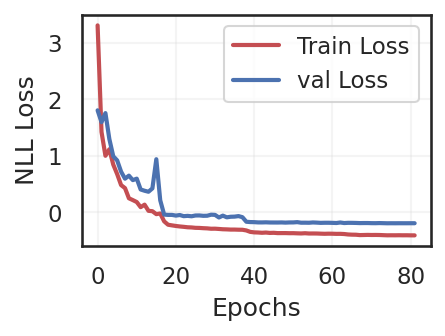

Train MSE: 0.18884789943695068
Test MSE: 0.16206826269626617


 36%|███▌      | 36/100 [00:55<01:39,  1.55s/it, loss=-0.309, val_loss=-0.107]

Early stopping triggered
Model No.2 trained.
-0.11163175478577614


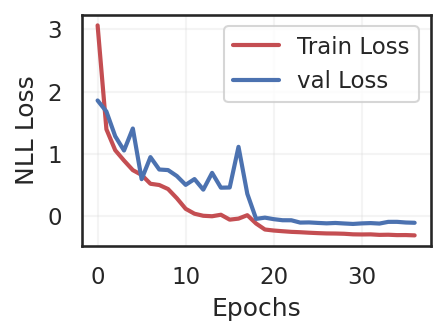

Train MSE: 0.215192049741745
Test MSE: 0.1973416656255722


 64%|██████▍   | 64/100 [01:38<00:55,  1.53s/it, loss=-0.414, val_loss=-0.205]

Early stopping triggered
Model No.3 trained.
-0.204970477947167


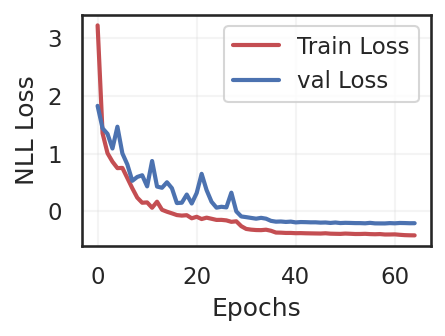

[I 2024-07-06 12:36:30,573] Trial 10 finished with value: -0.204970477947167 and parameters: {'learning_rate': 0.0002883180813851166, 'beta': 0.1, 'teacher_forcing_ratio': 0.7028631404149576, 'batch_size': 128, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'False', 'dropout': 0.21907864498279914}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.18686018884181976
Test MSE: 0.16710270941257477
Starting trial 11 with parameters: {}


 28%|██▊       | 28/100 [00:43<01:52,  1.57s/it, loss=-0.275, val_loss=-0.030]

Early stopping triggered
Model No.1 trained.
-0.042988759465515614


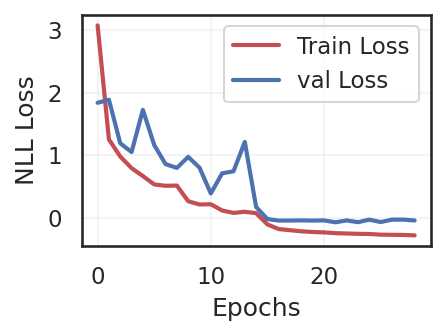

Train MSE: 0.23840384185314178
Test MSE: 0.21282902359962463


 27%|██▋       | 27/100 [00:42<01:54,  1.57s/it, loss=-0.274, val_loss=-0.049]

Early stopping triggered
Model No.2 trained.
-0.04518905268715961


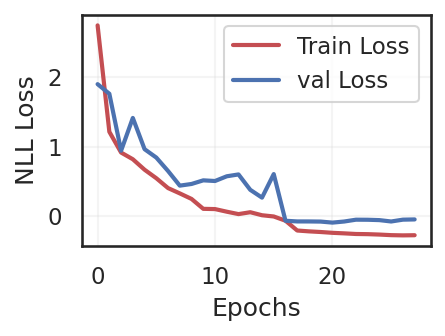

Train MSE: 0.24595926702022552
Test MSE: 0.22541719675064087


 26%|██▌       | 26/100 [00:41<01:56,  1.58s/it, loss=-0.285, val_loss=-0.021]

Early stopping triggered
Model No.3 trained.
-0.017458118897463595


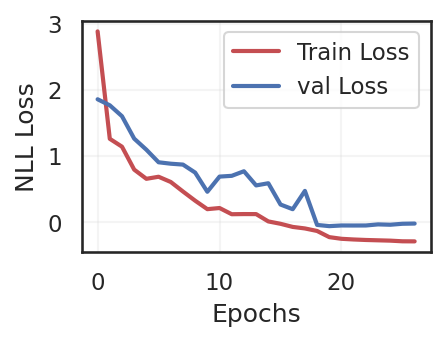

[I 2024-07-06 12:38:38,368] Trial 11 finished with value: -0.04518905268715961 and parameters: {'learning_rate': 0.00036030440849140876, 'beta': 0.1, 'teacher_forcing_ratio': 0.7753373983207195, 'batch_size': 128, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'False', 'dropout': 0.24960640242089638}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.23949800431728363
Test MSE: 0.21573489904403687
Starting trial 12 with parameters: {}


 21%|██        | 21/100 [00:33<02:05,  1.59s/it, loss=-0.238, val_loss=0.046] 

Early stopping triggered
Model No.1 trained.
0.02498162936951433


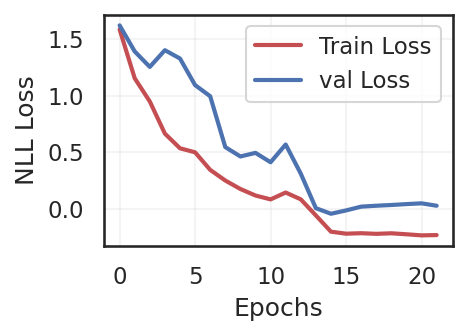

Train MSE: 0.26839014887809753
Test MSE: 0.2232292741537094


 22%|██▏       | 22/100 [00:35<02:04,  1.60s/it, loss=-0.221, val_loss=0.031]

Early stopping triggered
Model No.2 trained.
0.02502729105097907


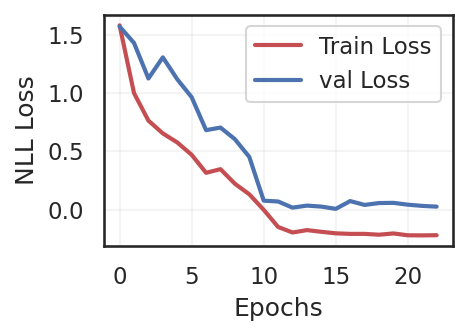

Train MSE: 0.2660183906555176
Test MSE: 0.23386088013648987


 20%|██        | 20/100 [00:31<02:07,  1.59s/it, loss=-0.006, val_loss=0.456]

Early stopping triggered
Model No.3 trained.
0.489560814840453


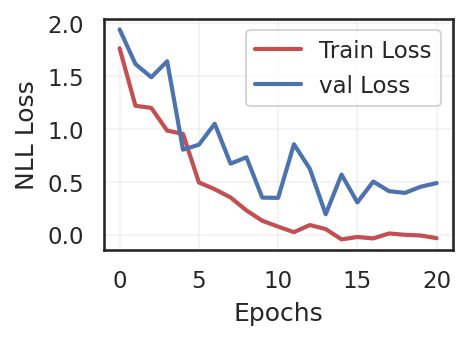

[I 2024-07-06 12:40:19,386] Trial 12 finished with value: 0.02498162936951433 and parameters: {'learning_rate': 0.0022913775563233843, 'beta': 0.1, 'teacher_forcing_ratio': 0.7394072767972328, 'batch_size': 128, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'False', 'dropout': 0.1002137249986606}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.5717605948448181
Test MSE: 0.4801180362701416
Starting trial 13 with parameters: {}


 27%|██▋       | 27/100 [00:43<01:56,  1.60s/it, loss=-0.235, val_loss=-0.032]

Early stopping triggered
Model No.1 trained.
-0.010482267609664373


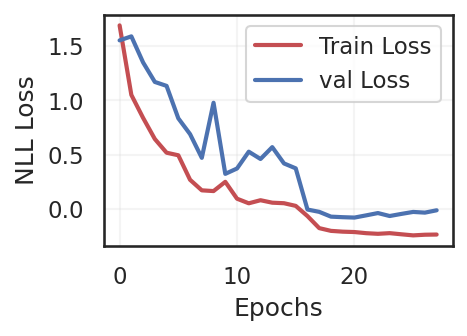

Train MSE: 0.2526090741157532
Test MSE: 0.2217201292514801


 19%|█▉        | 19/100 [00:30<02:09,  1.60s/it, loss=-0.219, val_loss=0.014] 

Early stopping triggered
Model No.2 trained.
0.005471671066646065


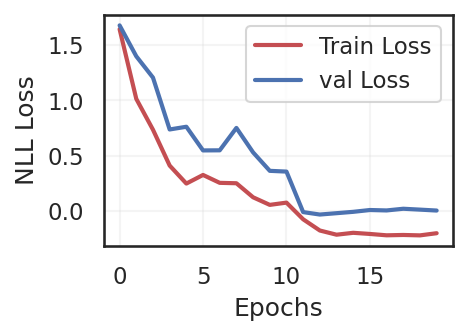

Train MSE: 0.25067058205604553
Test MSE: 0.2171110063791275


 23%|██▎       | 23/100 [00:36<02:03,  1.60s/it, loss=-0.237, val_loss=-0.027]

Early stopping triggered
Model No.3 trained.
-0.0005611374175974301


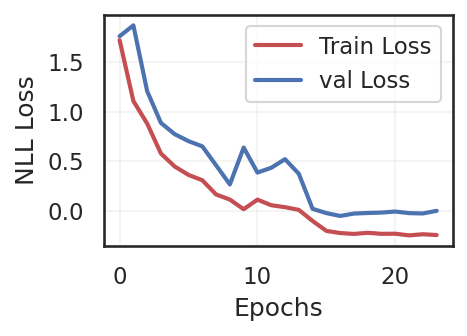

[I 2024-07-06 12:42:10,098] Trial 13 finished with value: -0.010482267609664373 and parameters: {'learning_rate': 0.0024686211657036407, 'beta': 0.1, 'teacher_forcing_ratio': 0.6703317597363839, 'batch_size': 128, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'False', 'dropout': 0.2726660731346474}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.25579094886779785
Test MSE: 0.22416675090789795
Starting trial 14 with parameters: {}


 16%|█▌        | 16/100 [00:25<02:15,  1.62s/it, loss=-0.093, val_loss=0.339]

Early stopping triggered
Model No.1 trained.
0.24609003482120378


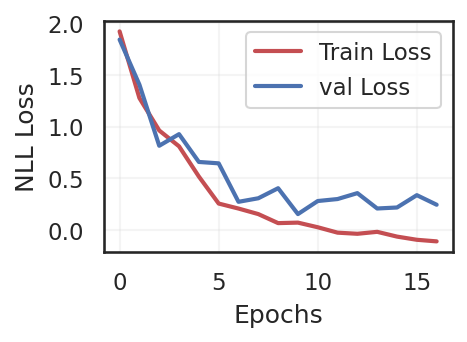

Train MSE: 0.3508774936199188
Test MSE: 0.32019734382629395


 41%|████      | 41/100 [01:03<01:31,  1.56s/it, loss=-0.358, val_loss=-0.125]

Early stopping triggered
Model No.2 trained.
-0.1453816153641258


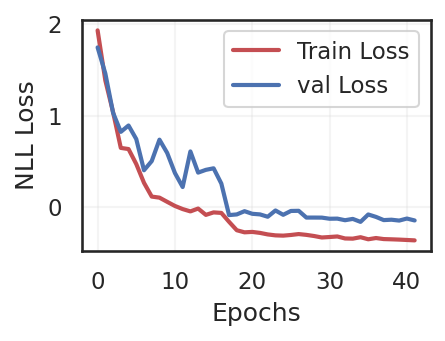

Train MSE: 0.19998374581336975
Test MSE: 0.18552684783935547


 73%|███████▎  | 73/100 [02:07<00:47,  1.75s/it, loss=-0.471, val_loss=-0.243]

Early stopping triggered
Model No.3 trained.
-0.24538461225373404


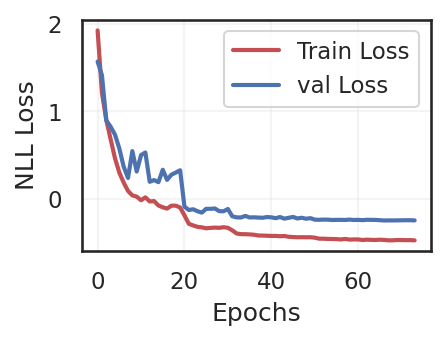

[I 2024-07-06 12:45:47,976] Trial 14 finished with value: -0.24538461225373404 and parameters: {'learning_rate': 0.0018069731097273604, 'beta': 0.1, 'teacher_forcing_ratio': 0.256243228061075, 'batch_size': 128, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.19737334642391718}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.17331159114837646
Test MSE: 0.14820779860019684
Starting trial 15 with parameters: {}


 35%|███▌      | 35/100 [01:29<02:46,  2.55s/it, loss=-0.293, val_loss=0.027] 

Early stopping triggered
Model No.1 trained.
0.03462974061923368


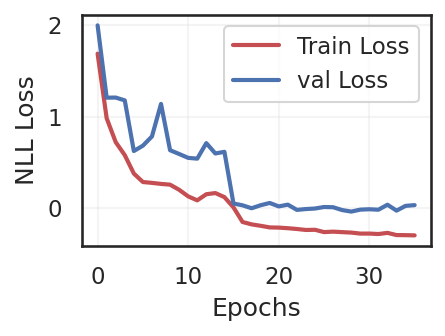

Train MSE: 0.24606263637542725
Test MSE: 0.23165452480316162


 26%|██▌       | 26/100 [01:08<03:14,  2.63s/it, loss=-0.292, val_loss=-0.046]

Early stopping triggered
Model No.2 trained.
-0.01146829899932657


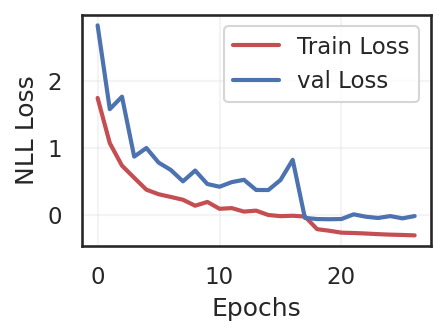

Train MSE: 0.2416742444038391
Test MSE: 0.21436475217342377


 30%|███       | 30/100 [01:15<02:55,  2.50s/it, loss=-0.088, val_loss=0.347]

Early stopping triggered
Model No.3 trained.
0.34228024791393963


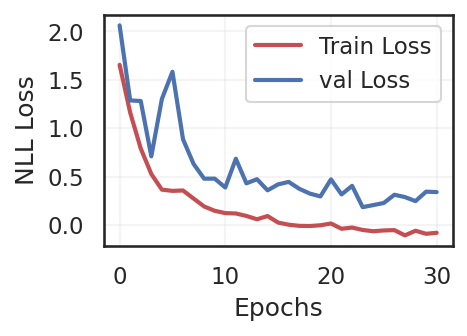

[I 2024-07-06 12:49:41,267] Trial 15 finished with value: -0.01146829899932657 and parameters: {'learning_rate': 0.003210195244570054, 'beta': 0.1, 'teacher_forcing_ratio': 0.2588968257872789, 'batch_size': 64, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.4302768245857139}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.4955507814884186
Test MSE: 0.5631989240646362
Starting trial 16 with parameters: {}


 33%|███▎      | 33/100 [00:56<01:53,  1.70s/it, loss=-0.266, val_loss=-0.103]

Early stopping triggered
Model No.1 trained.
-0.09890071695138301


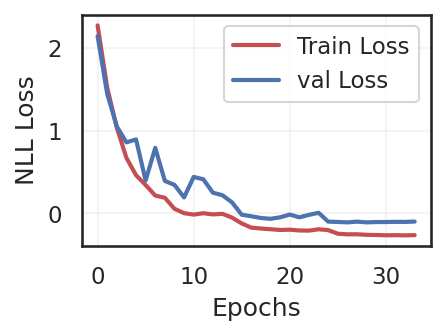

Train MSE: 0.18852806091308594
Test MSE: 0.17099273204803467


 18%|█▊        | 18/100 [00:33<02:30,  1.84s/it, loss=-0.024, val_loss=0.373]

Early stopping triggered
Model No.2 trained.
0.4165915136358568


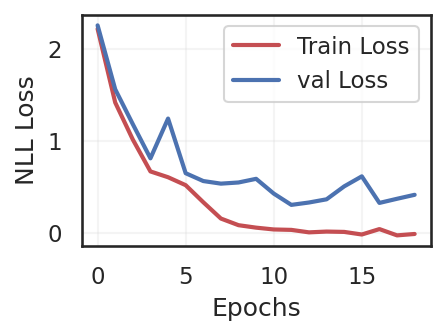

Train MSE: 0.5094327330589294
Test MSE: 0.555209219455719


 59%|█████▉    | 59/100 [01:40<01:09,  1.70s/it, loss=-0.316, val_loss=-0.118]

Early stopping triggered
Model No.3 trained.
-0.1336499069418226


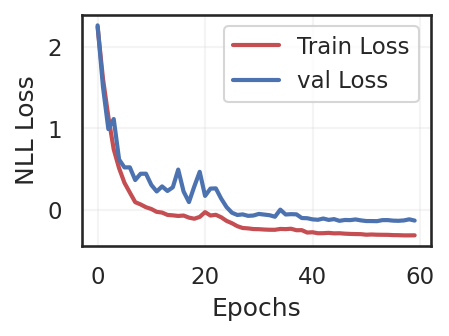

[I 2024-07-06 12:52:51,411] Trial 16 finished with value: -0.1336499069418226 and parameters: {'learning_rate': 0.001771134089340599, 'beta': 0.2, 'teacher_forcing_ratio': 0.23089401628172912, 'batch_size': 128, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.1122496374633129}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.17379336059093475
Test MSE: 0.15274271368980408
Starting trial 17 with parameters: {}


 13%|█▎        | 13/100 [01:01<06:50,  4.72s/it, loss=0.081, val_loss=0.984]

Early stopping triggered
Model No.1 trained.
0.7226422797647063


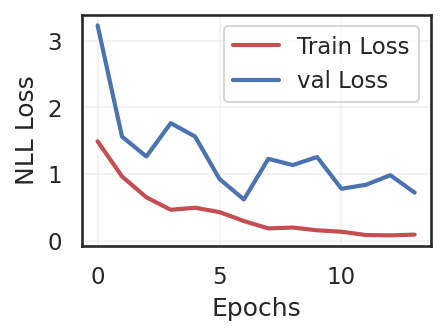

Train MSE: 0.5830935835838318
Test MSE: 0.6292229294776917


 53%|█████▎    | 53/100 [04:05<03:37,  4.64s/it, loss=-0.462, val_loss=-0.191]

Early stopping triggered
Model No.2 trained.
-0.19100346322024794


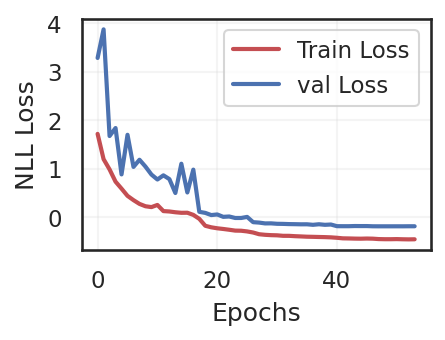

Train MSE: 0.19526319205760956
Test MSE: 0.17434082925319672


 41%|████      | 41/100 [03:07<04:29,  4.57s/it, loss=-0.403, val_loss=-0.086]

Early stopping triggered
Model No.3 trained.
-0.05258010535638918


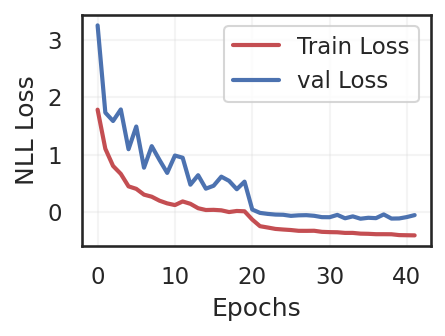

[I 2024-07-06 13:01:06,117] Trial 17 finished with value: -0.19100346322024794 and parameters: {'learning_rate': 0.004068655431938362, 'beta': 0.1, 'teacher_forcing_ratio': 0.336158302690003, 'batch_size': 32, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.29356801849401515}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.21398042142391205
Test MSE: 0.22544242441654205
Starting trial 18 with parameters: {}


 50%|█████     | 50/100 [01:28<01:28,  1.76s/it, loss=-0.420, val_loss=-0.141]

Early stopping triggered
Model No.1 trained.
-0.1366570182144642


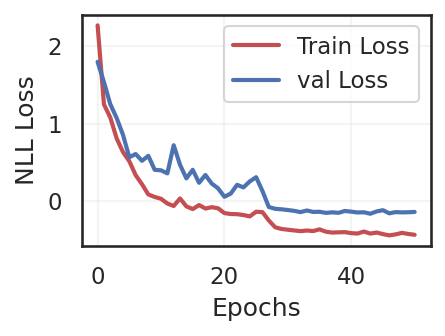

Train MSE: 0.19286370277404785
Test MSE: 0.17810238897800446


 30%|███       | 30/100 [00:56<02:11,  1.87s/it, loss=-0.347, val_loss=-0.076]

Early stopping triggered
Model No.2 trained.
-0.07008255619023528


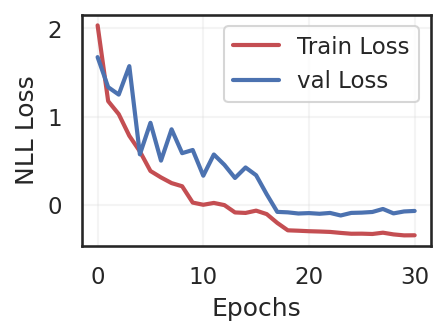

Train MSE: 0.2213577926158905
Test MSE: 0.20757856965065002


 28%|██▊       | 28/100 [00:49<02:08,  1.78s/it, loss=-0.369, val_loss=-0.125]

Early stopping triggered
Model No.3 trained.
-0.11598671334130424


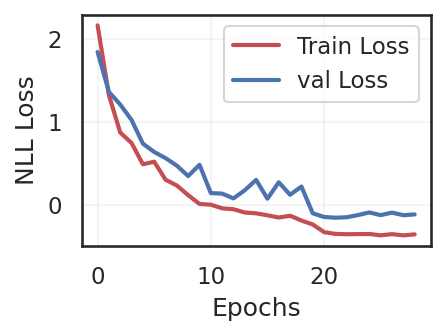

[I 2024-07-06 13:04:20,748] Trial 18 finished with value: -0.1366570182144642 and parameters: {'learning_rate': 0.0014139233761278375, 'beta': 0.1, 'teacher_forcing_ratio': 0.5820939479198621, 'batch_size': 128, 'optimizer_name': 'SGD', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.01789053351245723}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.2024991661310196
Test MSE: 0.19183854758739471
Starting trial 19 with parameters: {}


 30%|███       | 30/100 [01:01<02:24,  2.06s/it, loss=-0.121, val_loss=0.200]

Early stopping triggered
Model No.1 trained.
0.3550182386700596


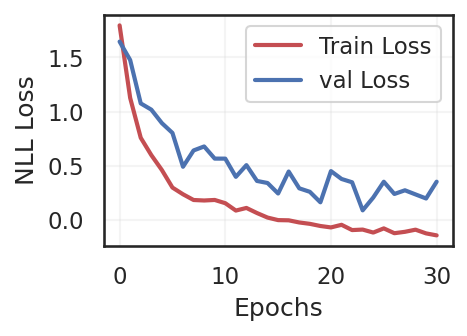

Train MSE: 0.49638909101486206
Test MSE: 0.3918716609477997


 57%|█████▋    | 57/100 [01:54<01:26,  2.01s/it, loss=-0.420, val_loss=-0.233]

Early stopping triggered
Model No.2 trained.
-0.23267052189580031


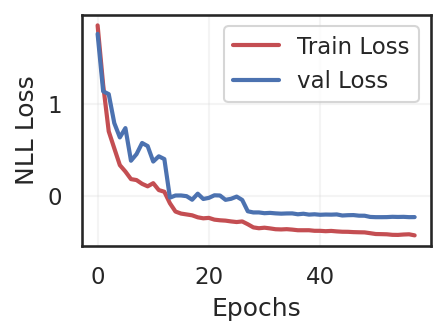

Train MSE: 0.1779778152704239
Test MSE: 0.15421199798583984


 52%|█████▏    | 52/100 [01:44<01:36,  2.02s/it, loss=-0.406, val_loss=-0.107]

Early stopping triggered
Model No.3 trained.
-0.09149793788258519


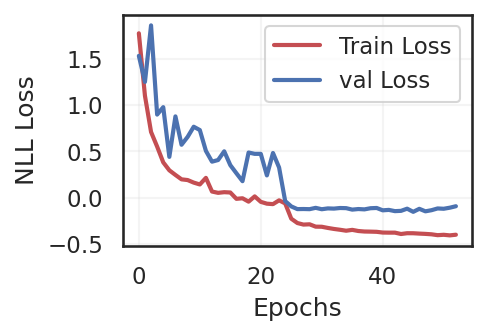

[I 2024-07-06 13:09:02,477] Trial 19 finished with value: -0.23267052189580031 and parameters: {'learning_rate': 0.003995427647796671, 'beta': 0.1, 'teacher_forcing_ratio': 0.13722207870274739, 'batch_size': 64, 'optimizer_name': 'Adam', 'hidden_size': 64, 'dynamic_tf': 'True', 'dropout': 0.43544410032597297}. Best is trial 7 with value: -0.2606735807244799.


Train MSE: 0.21303726732730865
Test MSE: 0.19537626206874847
Starting trial 20 with parameters: {}


 41%|████      | 41/100 [01:40<02:25,  2.46s/it, loss=-0.141, val_loss=0.036]
[W 2024-07-06 13:10:43,319] Trial 20 failed with parameters: {'learning_rate': 0.0027373237193884245, 'beta': 0.3, 'teacher_forcing_ratio': 0.30429572286864154, 'batch_size': 64, 'optimizer_name': 'Adam', 'hidden_size': 256, 'dynamic_tf': 'True', 'dropout': 0.20565815528334463} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/anshul/miniconda3/envs/uncertainty_aware/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_320846/1518907534.py", line 105, in objective
    loss, val_loss = model.train_model(device,
  File "/home/anshul/Research/Pred_unc_aware_planning/Deep_Ensemble/model.py", line 271, in train_model
    optimizer.step()
  File "/home/anshul/.local/lib/python3.10/site-packages/torch/optim/optimizer.py", line 140, in wrapper
    out = func(*args, **kwargs)
  File 

KeyboardInterrupt: 

In [ ]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials =40)

print("Best trial:")
trial = study.best_trial
print("Value:", trial.value)
print("params: ")
for key, value in trial.params.items():
    print(f" {key}: {value}")


optuna.visualization.plot_param_importances(study)
# import plotly
# from plotly import __version__ as plotly_version
# print(plotly_version)

optuna.visualization.matplotlib.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_rank(study)

/tmp/ipykernel_432589/1428420439.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.



In [28]:
study.best_params

{'learning_rate': 0.0030910254737853537,
 'beta': 0.1,
 'teacher_forcing_ratio': 0.6952979064310219,
 'batch_size': 128,
 'optimizer_name': 'RMSProp',
 'hidden_size': 256,
 'dynamic_tf': 'False',
 'dropout': 0.4016607535598246}

In [29]:
# Save Best params:
# params = {}
# params['dropout'] = dropout
# params['learning_rate'] = 0.008
# params['hidden_size'] = hidden_size
# params['batch_size'] = batch_size
# params['teacher_forcing_ratio'] = 0.88
# params['optimizer_name'] = 'Adam'
# params['dynamic_TF'] = False
# params['input_size'] = num_fea
# params['output_size'] = num_fea + 2
# params['num_layers'] =  num_layers
# params['num_models'] = num_models
# # params['weight_init'] = xavier_initialize

# with open('./Trained_models/Attn_model_hyperparams.pkl','wb') as f:
#     pkl.dump(params,f)


In [30]:
# Save Optuna Study:
# import pickle as pkl
# with open("Optuna_hyperparameter1.pkl", "wb") as f:
#     pkl.dump(study, f)

In [31]:
# Sigmoid function:
def sigmoid(list_x):
    return [1/(1+np.exp(-x)) for x in list_x]

# Inverse Function:
def inverse(list_x):
    return [1/(1e-4 + x) for x in list_x]

# relative loss:
def rel_loss(list_x):
    max_x = max(list_x)
    return [(max_x -x) for x in list_x]


# Weights:
def weights(list_x):
    return [x/sum(list_x) for x in list_x] 

# Weighted sum:
def weighted_sum(weights, array):
#     mu_ens = np.zeors_like(mu_preds[0])
    avg_ens = np.tensordot(weights, array, axes=([0], [0]))
    return avg_ens
        
    

In [32]:
def calculate_aggressive_weights(val_losses):
    # Shift the losses so the smallest loss is close to zero
    shifted_losses = val_losses - np.min(val_losses)

    # Apply a more aggressive inverse scaling: Square the inverse of shifted losses
    # Adding a small constant to avoid division by zero in inverse calculation
    aggressive_inverse_losses = 1 / (1e-4 + shifted_losses ** 3)

    # Normalize the new set of weights
    aggressive_weights = aggressive_inverse_losses / np.sum(aggressive_inverse_losses)

    return aggressive_weights



In [33]:
weights = calculate_aggressive_weights(ensemble_val_loss)
weights

NameError: name 'ensemble_val_loss' is not defined

In [ ]:
# # ensemble_val_loss = [0.053,0.01,0.014]
# inverse_list = inverse(ensemble_val_loss)
# rel_loss_list = rel_loss(ensemble_val_loss)

# # sigmoid_inv_list = sigmoid(inverse_list)
# # sigmoid_rel_loss_list = sigmoid(rel_loss_list)

# # Weights:
# weights_inv = weights(inverse_list)
# weights_rel_loss = weights(rel_loss_list)

In [ ]:
ensemble_predictions = []
for model in deep_ensemble.models:
    model.eval()
    
    with torch.no_grad():
        predictions = model.predict(test_input[:,0,:,:], target_len = forward_pred, device = device)
     
    ensemble_predictions.append(predictions)
ensemble_predictions = torch.stack(ensemble_predictions)    

In [ ]:
# Why torch.exp is used twice? : state Unc and Predictive Unc 
ensemble_predictions.shape
preds = torch.cat((ensemble_predictions[:,:,:,:int(num_fea/2)], torch.exp(ensemble_predictions[:,:,:,int(num_fea/2):int(num_fea)])),3)
sigmas = ensemble_predictions[:,:,:,int(num_fea):]
sigmas = torch.clamp(sigmas, min=min_logvar, max=max_logvar)
mu_preds = torch.Tensor(preds)
# mu_preds = denormalize_data(mu_preds, train_mean,  train_std)
sigma_preds = torch.Tensor(torch.exp(sigmas))

In [ ]:
preds[0,10,:,2:]

In [ ]:
test_output[200,1,:,2:]

In [ ]:
mu_preds.shape

In [ ]:
# Compute the ensemble mean and variance:
# mu_preds, sigma_preds =torch.stack(preds), torch.stack(sigmas) # Imp to convert a torch list to tensor

import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse

def plot_UQ(X_test, y_test, mus, sigmas, ground_cov, initial_pos,  id_no=100):
    
    num_fea = mus.shape[3]
#     sigmas = np.exp(sigmas)
    mu_preds = mus
    fig, axs = plt.subplots(nrows = 4, ncols =1, figsize =(12,12), sharex= True, sharey=False)
    for n_ens in range(mu_preds.shape[0]):

        axs[n_ens].scatter(X_test[id_no,:,0] + initial_pos[id_no,0],  X_test[id_no,:,1] +  initial_pos[id_no,1], color='g',marker='o',s =5, label = 'Input')
        axs[n_ens].plot(y_test[id_no,:,0] +  initial_pos[id_no,0],  y_test[id_no,:,1] + initial_pos[id_no,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
        axs[n_ens].plot(mu_preds[n_ens,id_no,:,0] +  initial_pos[id_no,0], mu_preds[n_ens,id_no,:,1] + initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate')

        num_fea = mu_preds.shape[3]
        var_state_unc = (mu_preds[n_ens,:,:,2:4]) 

        state_cov = []
        pred_cov = []
        mu = []
        for pred in range(forward_pred): 

            mean = np.squeeze(mu_preds[n_ens,id_no, pred, :2] + initial_pos[id_no,:])
            cov_pred = np.squeeze(np.diag(sigmas[n_ens,id_no,pred,:]))

            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))

            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)

    #         for pred in range(20):
    #             cov = np.cov(ground_cov[:,id_no,pred,0],ground_cov[:,id_no,pred,1] ) 
    #             lambda_, v_ = np.linalg.eig(cov)
    #             lambda_ = np.sqrt(lambda_)


    #             for j in range(2,3):
    #                 ell3 = Ellipse(xy = (ground_cov[:,id_no,pred,0].mean(), ground_cov[:,id_no,pred,1].mean()),
    #                          width = (lambda_[0] ) * j* 2 ,
    #                          height = (lambda_[1] ) *j* 2,
    #                             angle = np.degrees(np.arctan2(v_[1, 0], v_[0, 0])),
    #                              color = 'black',  lw = 0.5) 
    #                 ell3.set_facecolor('green')
    #                 ell3.set_alpha(0.25)
    #                 ax.add_artist(ell3)
    #             ell3.set_label("KF state uncertainty $(2\sigma)$")


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[n_ens].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[n_ens].add_artist(ell2)

        axs[n_ens].set_ylim([-15,15])
        axs[n_ens].set_xlim([-15,15])
        axs[n_ens].set_aspect('equal', adjustable='box')

    # Ensemble model Average:
    mu_ens = weighted_sum(weights, mu_preds) 
    axs[3].scatter(X_test[id_no,:,0] + initial_pos[id_no,0],  X_test[id_no,:,1] + initial_pos[id_no,1], color='g',marker='o',s =5, label = 'Input')
    axs[3].plot(y_test[id_no,:,0] + initial_pos[id_no,0],  y_test[id_no,:,1] + initial_pos[id_no,1], color='r',alpha=0.5, marker='^', ms =3,label = 'Ground Truth' )
    axs[3].plot(mu_ens[id_no,:,0] + initial_pos[id_no,0], mu_ens[id_no,:,1] + initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms = 3, label = 'NN state Estimate' )
    axs[3].set_ylim([-15,15])
    axs[3].set_xlim([-15,15])
    axs[3].set_aspect('equal', adjustable='box')

    var_aleatoric = weighted_sum(weights, sigmas[:,:,:,:2])
    var_epistemic = weighted_sum(weights, mu_preds[:,:,:,:2]**2) - mu_ens[:,:,:2]**2
    var_ens = var_aleatoric  + var_epistemic

    var_state_unc = (weighted_sum(weights, mu_preds[:,:,:,2:4])) 
#     print(var_state_unc)

    for pred in range(forward_pred): 

            mean = np.squeeze(mu_ens[id_no, pred, :2] + initial_pos[id_no,:])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no,pred,:])))

            # Total Variance:
            cov_state = np.squeeze(var_state_unc[id_no, pred,:2])
            cov_state = np.diag(np.squeeze(cov_state))


            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)

            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)


            for j in range(1,2):
                ell1 = Ellipse(xy = (mean[0], mean[1]),
                         width = ( 1* lambda_ale[0] ) * j* 2 ,
                         height = ( 1*lambda_ale[1] ) *j* 2,
                            angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                             color = 'none',  lw = 0.5) 
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2/j)
                axs[3].add_artist(ell1)

                ell2 = Ellipse(xy = (mean[0], mean[1]),
                     width = (lambda_tot[0]) * j* 2,
                     height = (lambda_tot[1]) *j* 2,
                        angle = np.rad2deg(np.arccos((v_ale[0,0]))),
                     color = 'none', linestyle  ='--', lw = 0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4/j)
                axs[3].add_artist(ell2)
    plt.show()

In [ ]:
id_list = [36]

for id_no in id_list:
    plot_UQ (test_input[:,1,:,:].detach().cpu().numpy(),
                          test_output[:,1,:,:].detach().cpu().numpy(), 
                          mu_preds.detach().cpu().numpy(), 
                          sigma_preds.detach().cpu().numpy(), 
                          gaussian_test_traj.detach().cpu().numpy(),
                          test_init_pos,
                          id_no = id_no)

In [ ]:
## Animate the Trajectory for visualizing UQ:
import matplotlib.animation as animation

def animate_UQ(X_test, y_test, mus, sigmas, ground_cov, initial_pos, id_list):
    num_fea = mus.shape[3]
    mu_preds = mus
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Define the initialization function to clear the plot
    def init():
        ax.clear()
        ax.set_xlim([-15, 15])
        ax.set_ylim([-15, 15])
        ax.set_aspect('equal', adjustable='box')
        return ax,
    
    # Define the animation function
    def animate(id_no):
        ax.clear()
        ax.set_xlim([-15, 15])
        ax.set_ylim([-15, 15])
        ax.set_aspect('equal', adjustable='box')

        ax.scatter(X_test[id_no, :, 0] + initial_pos[id_no,0], X_test[id_no, :, 1] + initial_pos[id_no,1], color='g', marker='o', s=5, label='Input')
        ax.plot(y_test[id_no, :, 0] + initial_pos[id_no,0], y_test[id_no, :, 1] + initial_pos[id_no,1], color='r', alpha=0.5, marker='^', ms=3, label='Ground Truth')
        
        mu_ens = weighted_sum(weights, mu_preds)
        ax.plot(mu_ens[id_no, :, 0] + initial_pos[id_no,0], mu_ens[id_no, :, 1] + initial_pos[id_no,1], color='b', marker='d', alpha=0.85, ms=3, label='NN state Estimate')

        var_aleatoric = weighted_sum(weights, sigmas[:, :, :, :2])
        var_epistemic = weighted_sum(weights, mu_preds[:, :, :, :2] ** 2) - mu_ens[:, :, :2] ** 2
        var_ens = var_aleatoric + var_epistemic
        var_state_unc = weighted_sum(weights, mu_preds[:, :, :, 2:4])
        
        for pred in range(forward_pred):
            mean = np.squeeze(mu_ens[id_no, pred, :2]  + initial_pos[id_no,:])
            cov_pred = np.squeeze(np.squeeze(np.diag(var_ens[id_no, pred, :])))
            cov_state = np.squeeze(var_state_unc[id_no, pred, :2])
            cov_state = np.diag(np.squeeze(cov_state))
            
            lambda_tot, v_tot = np.linalg.eig(cov_pred)
            lambda_tot = np.sqrt(lambda_tot)
            lambda_ale, v_ale = np.linalg.eig(cov_state)
            lambda_ale = np.sqrt(lambda_ale)
            
            for j in range(1, 2):
                ell1 = Ellipse(xy=(mean[0], mean[1]),
                               width=(1 * lambda_ale[0]) * j * 2,
                               height=(1 * lambda_ale[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', lw=0.5)
                ell1.set_facecolor('tab:blue')
                ell1.set_alpha(0.2 / j)
                ax.add_artist(ell1)

                ell2 = Ellipse(xy=(mean[0], mean[1]),
                               width=(lambda_tot[0]) * j * 2,
                               height=(lambda_tot[1]) * j * 2,
                               angle=np.rad2deg(np.arccos((v_ale[0, 0]))),
                               color='none', linestyle='--', lw=0.25)
                ell2.set_facecolor('tab:olive')
                ell2.set_alpha(0.4 / j)
                ax.add_artist(ell2)

        # ax.legend()
        return ax,

    ani = animation.FuncAnimation(fig, animate, frames=id_list, init_func=init, blit=False, repeat=False)
    anim_writer = animation.PillowWriter(fps=2)
    ani.save('Trajectory3.gif', writer=anim_writer)
    plt.show()

# Example usage
id_list = list(range(10,16))  # Add more IDs as needed
animate_UQ(test_input[:, 1, :, :].detach().cpu().numpy(),
           test_output[:, 1, :, :].detach().cpu().numpy(),
           mu_preds.detach().cpu().numpy(),
           sigma_preds.detach().cpu().numpy(),
           gaussian_test_traj.detach().cpu().numpy(),
           test_init_pos,
           id_list)

In [ ]:
mu_preds.shape

In [ ]:
from utils import *

# Compute the average Displacement and final displacement error:
ADE = average_displacement_error(forward_pred, mu_preds, torch.tensor(y_test).float().to(device).unsqueeze(0))
FDE = final_displacement_error(forward_pred, mu_preds, torch.tensor(y_test).float().to(device).unsqueeze(0))


In [ ]:
FDE

In [ ]:
ADE

In [ ]:
# Saving the objects:
import pickle as pkl
PATH = r'C:\Users\n2kan\OneDrive - Virginia Tech\Anshul\Research\Ph.D\Uncertainty Estimation\Trajectory_Prediction\Uncertainty_aware\Deep_Ensemble\Trained_models'
with open(os.path.join(PATH, 'test_data.pkl'), 'wb') as f:  # Python 3: open(..., 'wb')
    pkl.dump([test_input, test_output, gaussian_test_traj], f)
    f.close()

with open(os.path.join(PATH,'weights.pkl'), 'wb') as f:
    pkl.dump(weights,f)
    f.close()

with open (os.path.join(PATH,'test_df.pkl'), 'wb') as f:
    pkl.dump([df, test_agents],f)
    f.close()

In [ ]:
# Load and save model for inference:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
for i, model  in enumerate(deep_ensemble.models):
    model_path = os.path.join(PATH, f"model_{i}_parameters.pth")
    torch.save(model.state_dict(), model_path )

model_path = os.path.join(PATH, 'ensemble_model.pth')    
torch.save(deep_ensemble.state_dict(), model_path)

# torch.save(weights, "/home/anshulnayak/Trajectory_Prediction/Results/Deep_Ensemble/Trained_models/ensemble_weights.pth")

In [ ]:
gaussian_test_traj.shape

In [ ]:
PICP = coverage_probability(mu_preds.detach().cpu().numpy(), y_test, sigma_preds.detach().cpu().numpy())
# PICP_y = coverage_probability(mu_preds.detach().cpu().numpy(), np.expand_dims(y_test, axis = 0), sigma_preds.detach().cpu().numpy(), axis = 1)
MPIW = prediction_interval_width(mu_preds.detach().cpu().numpy(), y_test, sigma_preds.detach().cpu().numpy())

In [ ]:
MPIW_x = MPIW[:,0]
MPIW_y = MPIW[:,1]

In [ ]:
plt.hist(PICP)

In [ ]:
'''
Other methods to compute the data for training and validation.
'''
# batch_cov = (batch_cov[:,:,:,:2,:2])
# batch_gaussian =  np.concatenate([batch_mu[:,:,:,:num_fea], (batch_cov.reshape(batch_cov.shape[:-2] + (-1,)))], axis =3) # shape: batch, num_traj, seq, features *2
# batch_gaussian = torch.tensor(batch_gaussian).float().to(device)
# batch_gaussian_input, batch_gaussian_output = torch.split(batch_gaussian, [8,12], dim = 2)

# batch_cov_test = (batch_cov_test[:,:,:,:2,:2])
# batch_gaussian_test = np.concatenate([batch_mu_test[:,:,:,:num_fea], (batch_cov_test.reshape(batch_cov_test.shape[:-2] + (-1,)))], axis =3)# shape: batch, num_traj, seq, features *2
# batch_gaussian_test = torch.tensor(batch_gaussian_test).float().to(device)
# # batch_gaussian_test = reshape_data(batch_gaussian_test)
# batch_gaussian_test_input, batch_gaussian_test_output = torch.split(batch_gaussian_test, [8,12], dim = 2)



# # Data augmentation for aleatoric uncertainty:
# X_train_KF_aug, y_train_KF_aug = reshape_data(X_train_KF), reshape_data(y_train_KF)
# X_test_KF_aug, y_test_KF_aug = reshape_data(X_test_KF), reshape_data(y_test_KF)

# X_train_aug, y_train_aug = X_train.unsqueeze(1).repeat(1, num_traj, 1,  1), y_train.unsqueeze(1).repeat(1, num_traj, 1, 1)
# X_test_aug, y_test_aug   = X_test.unsqueeze(1).repeat(1, num_traj, 1,  1), y_test.unsqueeze(1).repeat(1, num_traj, 1,  1)

# X_train_aug, y_train_aug = reshape_data(X_train_aug), reshape_data(y_train_aug)
# X_test_aug, y_test_aug =   reshape_data(X_test_aug), reshape_data(y_test_aug)

In [ ]:
# import scipy.io
# scipy.io.savemat('state_covariance.mat', mdict={'state_cov':state_cov})
# scipy.io.savemat('Predictive_covariance.mat', mdict={'pred_cov':pred_cov})
# mu.shape
# scipy.io.savemat('mean.mat', mdict={'mu':mu})

In [ ]:
# import pickle as pkl
# with open('/home/anshulnayak/Trajectory_Prediction/Results/Deep Ensemble/Input_uncertainty/xy_no_full_state/zara_01/input_unc_xy_M_3_noise_5','wb') as f:
#     pkl.dump([X_test, y_test, mu_preds, sigma_preds, batch_gaussian_test], f)


# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/state_unc.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    

In [ ]:
plt.hist(MPIW_y,bins = 20)

In [ ]:
plt.hist(MPIW_x,bins = 20)

In [ ]:
np.mean(PICP)

In [ ]:
df = pd.DataFrame({'PICP': PICP,
                   'MPIW_x': MPIW_x,
                   'MPIW_y': MPIW_y})

columns = ['PICP', 'MPIW_x','MPIW_y']
print(len(df.columns))
df[columns[0]]

In [ ]:
# import pickle as pkl
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3_noise_2pt5.dat','rb') as f:
#     df1=pkl.load(f)

In [ ]:
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3_noise_5.dat','rb') as f:
#     df2=pkl.load(f)

In [ ]:
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3.dat','rb') as f:
#     df3=pkl.load(f)

In [ ]:
# with open('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/df_eth_input_unc_2N_param_xyuv_M_3_noise_20.dat','rb') as f:
#     df4=pkl.load(f)

In [ ]:
# df = pd.DataFrame({'PICP': [ df1.iloc[:,0], df2.iloc[:,0], df3.iloc[:,0],   df4.iloc[:,0]],
#                    'MPIW_x': [ df1.iloc[:,1], df2.iloc[:,1], df3.iloc[:,1], df4.iloc[:,1]],
#                    'MPIW_y': [df1.iloc[:,2], df2.iloc[:,2],  df3.iloc[:,2], df4.iloc[:,2]]})

df = pd.DataFrame({'PICP': [ PICP],
                   'MPIW_x': [ MPIW_x],
                   'MPIW_y': [ MPIW_y]})

# plt.style.use('ggplot')
sns.set_style("white")
fig, axs  = plt.subplots(1,len(df.columns), figsize=(6, 4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2, hspace=2)
# ax2 = ax.twinx()

my_ticks = ['5']
my_pal  =  ['Blues', 'Greens', 'Reds']
red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor='white')
mean_shape = dict(markerfacecolor='white', marker='D', markeredgecolor='black')
titles = ['PICP', '$\mathrm{MPIW_{x}}$', '$\mathrm{MPIW_{y}}$']

for i, ax in enumerate(axs.flat):
    
    sns.boxplot(  data = df.iloc[:,i], width = 0.35, saturation = 0.7, flierprops=red_circle, showmeans=True,
                     meanprops = mean_shape, ax = ax, palette = sns.color_palette(my_pal[i]))
    df.iloc[:,i]
    ax.set_title(titles[i],  y= - 0.22, fontsize=16, fontweight='normal')
#     ax.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
#     ax.set_xticks(range(len(df.columns)))''
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = my_ticks
    ax.set_xticklabels(labels)

    
    for label in (ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels()):
        label.set_fontsize(14)
        label.set_fontweight('bold')
        label.set_fontname('P052')

fig.tight_layout()




# fig.suptitle('Prediction Metrics', fontsize=20)
# plt.savefig('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/Plot_metrics_measurement_noise.png', dpi=600)
# plt.savefig('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/Plot_metrics_measurement_noise.pdf', dpi=300)
# plt.savefig('/home/anshulnayak/Dataset/Results/Deep Ensemble/Input_uncertainty/input_2N_params/Plot_metrics_measurement_noise.eps', dpi=300)


In [ ]:
np.mean(PICP), np.mean(MPIW_x), np.mean(MPIW_y)

In [ ]:
df_eth = pd.DataFrame({'PICP': PICP,
                      'MPIW_x': MPIW_x,
                      'MPIW': MPIW_y,
                      'ADE': ADE,
                      'FDE': FDE})



In [ ]:
# import pickle
# pickle.dump(df_eth, open("/home/anshulnayak/Trajectory_Prediction/Results/Deep Ensemble/Input_uncertainty/xy_no_full_state/zara_01/df_ucy_xy_M_3_noise_5.dat","wb"))


In [ ]:
sigma_preds = torch.exp(sigma_preds)
mu_ens = torch.mean(mu_preds, axis=0)
# sigma_ens = torch.sqrt((torch.sum(torch.square(mu_preds) + torch.square(sigma_preds),axis=0))/sigma_preds.shape[0] - torch.square(mu_ens))
var_ens = (sigma_preds + mu_preds.pow(2)).mean(dim=0) - mu_ens.pow(2)
var_aleatoric = sigma_preds.mean(dim=0)
var_epistemic = mu_preds.pow(2).mean(dim=0) - mu_ens.pow(2)
sigma_ens = torch.sqrt(var_ens)

In [ ]:
sigma_ens[1,:,3]

In [ ]:
mu_preds.shape

In [ ]:
sns.set(rc={'figure.figsize':(10,3)})

# .detach().cpu().numpy()
id = 2
for traj in range(batch_traj_test.detach().cpu().numpy().shape[1]):
    plt.plot(batch_traj_test[id,traj, :, 0].detach().cpu().numpy(), batch_traj_test[id,traj, :, 1].detach().cpu().numpy())
    plt.plot(test_traj[id,:,0],test_traj[id,:,1], lw=2., ms=12., marker='*', color="r", linestyle="dashed")
#     plt.ylim([6,10])
plt.show()

In [ ]:


def unsqueeze_data(X):
    X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3])
    return X

In [ ]:
batch_gaussian_test_output.shape

def plot_trajectory(x_true, y_true, y_pred, idx=0):
    plt.figure(figsize=(10, 3), dpi=150)
    plt.scatter(x_true[idx,:,0], x_true[idx,:,1], color='g', label="Input", marker='o', s = 80)
    plt.scatter(y_true[idx,:,0], y_true[idx,:,1], color='b', label="Actual", alpha=0.3, marker='o',s = 80)
    plt.scatter(y_pred[idx,:,0], y_pred[idx,:,1], color='r', label="Predicted", marker='o',s = 80)
    plt.legend(loc="upper right", fontsize=12)
    plt.show()

In [ ]:
def plot_trajectory_uncertainty(x_true, y_true, y_pred, y_pred_var , idx):
    
    sns.set_theme(style='white')
    plt.figure(figsize=(10,9))
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,6), sharex=False, sharey=True)
    plt.tight_layout()
    
    y_pred_ens = np.mean(y_pred, axis=0)
    var_ens = np.mean((y_pred_var + y_pred**2), axis = 0) - y_pred_ens**2
    var_aleatoric = np.mean(y_pred_var, axis = 0)
    var_epistemic = np.mean(y_pred**2, axis = 0) - y_pred_ens**2
#     mu_ens = torch.mean(mu_preds, axis=0)
#     # sigma_ens = torch.sqrt((torch.sum(torch.square(mu_preds) + torch.square(sigma_preds),axis=0))/sigma_preds.shape[0] - torch.square(mu_ens))
#     var_ens = (sigma_preds + mu_preds.pow(2)).mean(dim=0) - mu_ens.pow(2)
#     var_aleatoric = sigma_preds.mean(dim=0)
#     var_epistemic = mu_preds.pow(2).mean(dim=0) - mu_ens.pow(2)
    sigma_ens, sigma_aleatoric, sigma_epistemic = np.sqrt(var_ens), np.sqrt(var_aleatoric), np.sqrt(var_epistemic)

#     y_train_pred_mean, y_train_pred_logvar = y_train_pred[:,:,:4].detach().cpu().numpy(), y_train_pred[:,:,4:].detach().cpu().numpy()
#     y_train_pred_var = np.exp(y_train_pred_logvar)  
    axs[0].plot(x_true[idx,:,0], x_true[idx,:,1], color='g',marker='o')
    axs[0].plot(y_true[idx,:,0], y_true[idx,:,1], color='r',alpha=0.75, marker='^')
    axs[0].plot(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1], color='b', marker='d')

  # for i in range(5):
  #   plt.errorbar(y_pred[i,id,:,0], y_pred[i,id,:,1], xerr= 2* y_pred_var[i,id,:,0], yerr= 2* y_pred_var[i,id,:,1], color='r', label="predicted trajectory", marker='s')
  

  # mu_ens = np.mean(mu_preds, axis=0)
  # plt.plot(mu_ens[id,:,0], mu_ens[id,:,1],  color='k', label="Ensemble trajectory", alpha=0.9, linewidth = 3)


  # l, caps, c = plt.errorbar(y_pred[id,:,0], y_pred[id,:,1], xerr= 2* y_pred_var[id,:,0], yerr= 2* y_pred_var[id,:,1], fmt='o', ecolor='k', 
  #                           capthick=2, alpha = 0.8, label='$\mu$, $2\sigma_{x}$, $2\sigma_{y}$')
  
    axs[0].fill_between(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1] - 2* sigma_ens[idx,:,1],
                       y_pred_ens[idx,:,1] + 2* sigma_ens[idx,:,1], alpha = 0.2,label='Total Uncertainty')
    axs[0].grid("on", alpha = 0.5)

        
    axs[1].plot(x_true[idx,:,0], x_true[idx,:,1], color='g', marker='o')
    axs[1].plot(y_true[idx,:,0], y_true[idx,:,1], color='r', alpha=0.75, marker='^')
    axs[1].plot(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1], color='b', marker='d')
    axs[1].fill_between(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1] - 2* sigma_aleatoric[idx,:,1],
                       y_pred_ens[idx,:,1] + 2* sigma_aleatoric[idx,:,1], alpha = 0.2,label='Aleatoric Uncertainty')
    axs[1].grid("on", alpha = 0.5)
    
    axs[2].plot(x_true[idx,:,0], x_true[idx,:,1], color='g', label="Input ", marker='o')
    axs[2].plot(y_true[idx,:,0], y_true[idx,:,1], color='r', label="Ground Truth", alpha=0.75, marker='^')
    axs[2].plot(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1], color='b',label='Predicted', marker='d')
    axs[2].fill_between(y_pred_ens[idx,:,0], y_pred_ens[idx,:,1] - 2* sigma_epistemic[idx,:,1],
                       y_pred_ens[idx,:,1] + 2* sigma_epistemic[idx,:,1], alpha = 0.2,label='Epistemic Uncertainty')
    axs[2].grid("on", alpha = 0.5)
    
#     label='$\mu$, $2\sigma_{y}$'

#     plt.legend(loc="upper left", fontsize = 16)
    for a in axs:
        a.set_ylabel('y (m)', fontsize=18, fontweight ='bold')
        a.legend()
        if a == axs[-1]:
            a.set_xlabel('x (m)', fontsize=18, fontweight ='bold')
        elif a == axs[0]:
            a.set_title('idx = %d' %idx)

        for label in (a.get_xticklabels() + a.get_yticklabels()):
            label.set_fontsize(16)
            label.set_fontweight('bold')
#     plt.xlabel('x (m)', fontsize=16)
#     plt.ylabel('y (m)', fontsize=16)
      # plt.xlim([-1,-3])
      # plt.ylim([2,4])
    plt.grid("on", alpha = 0.5)
    plt.setp(ax.get_xticklabels(), fontsize=16)

    ax.tick_params(axis='x', labelsize=16)
    plt.savefig('Deep_Ensemble.png', bbox_inches='tight',dpi = 300)
    plt.show()

for idx in np.random.choice(X_test_KF.shape[0],20):  
    plot_trajectory_uncertainty(x_true = X_test_KF[:,2,:,:].detach().cpu().numpy(), 
                    y_true = y_test_KF[:,2,:,:].detach().cpu().numpy(), 
                    y_pred = mu_preds.detach().cpu().numpy(), 
                    y_pred_var = sigma_preds.detach().cpu().numpy(), 
                    idx = idx)   #Check whether train or test data

In [ ]:
idx = 145
plot_trajectory_uncertainty(x_true = batch_gaussian_test_input[:,2,:,:].detach().cpu().numpy(), 
                    y_true = batch_gaussian_test_output[:,2,:,:].detach().cpu().numpy(), 
                    y_pred = mu_preds.detach().cpu().numpy(), 
                    y_pred_var = sigma_preds.detach().cpu().numpy(), 
                    idx = idx)

In [ ]:
X_test_KF[200,2,:,:]

In [ ]:
X_test_KF.shape

In [ ]:
X_test_KF.shape

In [ ]:
idx = 195
plot_trajectory_uncertainty(x_true = batch_gaussian_test_input[:,2,:,:].detach().cpu().numpy(), 
                    y_true = batch_gaussian_test_output[:,2,:,:].detach().cpu().numpy(), 
                    y_pred = mu_preds.detach().cpu().numpy(), 
                    y_pred_var = sigma_preds.detach().cpu().numpy(), 
                    idx = idx)  

In [ ]:
X_test.shape[0]

In [ ]:
print(ADE)
print(FDE)

In [ ]:
# Performance Prediction Interval:
# PICP : Prediction interval coverage probability ( 1 - alpha)
# MPIW : Mean Predictive Interval Width

# Coverage plot for prediction interval:

def coverage_probability(y_pred, y_true, y_pred_var, axis = 0):
    
    mean = np.mean(y_pred.detach().cpu().numpy(), axis = 0)
    var_ens = np.mean((y_pred_var.detach().cpu().numpy() + y_pred.detach().cpu().numpy()**2), axis = 0) - mean**2
    sigma_ens =  np.sqrt(var_ens)
    sigma_data = np.sqrt(np.abs(mean)) + sigma_ens
#     std = sigma_ens + sigma_data
    cnt = []
    for id in range(y_pred.shape[1]):
        flag = 0
        nugget = 1e-4
        for n in range(y_pred.shape[2]):
             if (mean[id,n, axis] - 1*(sigma_ens[id,n,axis] +  sigma_data[id,n,axis+2]) < np.squeeze(y_true.detach().cpu().numpy()))[id,n,axis] \
                    < (mean[id,n,axis] + 1*(sigma_ens[id,n,axis] +  sigma_data[id,n,axis+2])):
                    flag += 1
    
        cnt.append((flag)/12.0)
    cnt = np.array(cnt)
    return cnt



# Prediction Interval Width:

def prediction_interval_width(y_pred, y_true,  y_pred_var, axis = 0):
    mean = np.mean(y_pred.detach().cpu().numpy(), axis = 0)
    var_ens = np.mean((y_pred_var.detach().cpu().numpy() + y_pred.detach().cpu().numpy()**2), axis = 0) - mean**2
    sigma_ens =  np.sqrt(var_ens)
    sigma_data = np.sqrt(np.abs(mean)) + sigma_ens
#     std = sigma_ens + sigma_data
   
    batch_width = []
    for id in range(y_pred.shape[1]):
        width = []
        for n in range(y_pred.shape[2]):
            temp = 2*np.abs((sigma_ens[id,n,axis] +  sigma_data[id,n,axis+2]))
            width.append(temp)
        width = np.array(width)
        batch_width.append(width)
    batch_width = np.array(batch_width)
    mean_width = np.mean(batch_width, axis = 1)
    
    return batch_width, mean_width

In [ ]:
PICP_x = coverage_probability(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 0)
PICP_y = coverage_probability(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 1)

In [ ]:
_, MPIW_x = prediction_interval_width(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 0)
_, MPIW_y = prediction_interval_width(mu_preds, torch.squeeze(batch_gaussian_test_output[:,2,:,:]).unsqueeze(0), sigma_preds, axis = 1)

In [ ]:
plt.hist(MPIW_x, bins = 30)

In [ ]:
PICP_x.shape

In [ ]:
plt.hist(PICP_y)

In [ ]:
np.mean(PICP_y)

In [ ]:
df = pd.DataFrame({'PICP': PICP_x,
                   'MPIW': MPIW_x})

fig, ax1  = plt.subplots(figsize=(7.8, 5.51))

props = dict(widths=0.7,patch_artist=True, medianprops=dict(color="gold"))
box1=ax1.boxplot(df['PICP'].mask(df['PICP'] ==0).values, positions=[0], **props)

ax2 = ax1.twinx()
box2=ax2.boxplot(df[['MPIW']].values,positions=[1], **props)

ax1.set_xlim(-0.5,2.5)
ax1.set_xticks(range(len(df.columns)))
ax1.set_xticklabels(df.columns)
fig.suptitle('Prediction Metrics', fontsize=20)

In [ ]:
df['PICP']

In [ ]:
df_eth = pd.DataFrame({'PICP': PICP_x,
                      'MPIW_x': MPIW_x,
                      'MPIW': MPIW_y})


In [ ]:
import pickle
pickle.dump(df_x_eth_total, open("Dataset/Results/Deep Ensemble/df_x_eth_total.dat","wb"))


In [ ]:
# Sample from multivariate distribution
from torch.distributions.multivariate_normal import MultivariateNormal
id = 100
sns.set(rc={'figure.figsize':(10,3)})
traj = []
for i in range(8):
    z = MultivariateNormal(loc = Xs_batch[id,i,:2], covariance_matrix =  cov_batch[id,i,:,:])
    pred =  z.rsample(sample_shape=torch.Size([10])).to(device)
    # Plot density function.
    #     plt.contourf(x, y)
#     sns.kdeplot(x=z[0], y=z[1],space = 0)

        
    sns.scatterplot(pred[:,0].detach().cpu().data.numpy(),pred[:,1].detach().cpu().data.numpy()
                    , marker="o", s = 100)
#     traj.append(z)
    
g = sns.scatterplot(X_train[id,:,0].detach().cpu().data.numpy(),X_train[id,:,1].detach().cpu().data.numpy(),color='k', marker="X", s = 400)
# g.set_ylim(5,8)
# g.set_xlim(4.5,8.5)


plt.show()

In [ ]:
i = 5
z = MultivariateNormal(loc = Xs_batch[id,i,:2], covariance_matrix =  cov_batch[id,i,:,:])
z.rsample(sample_shape=torch.Size([10]))